# PHIStruct: Improving phage-host interaction prediction at low sequence similarity settings using structure-aware protein embeddings

<b>Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2, 3</sup> & Anish M.S. Shrestha<sup>1, 2</sup></b>

<sup>1</sup> Bioinformatics Lab, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila 1004, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila 1004, Philippines <br>
<sup>3</sup> Walter and Eliza Hall Institute of Medical Research, Melbourne, Victoria, 3052, Australia

✉️ gonzales.markedward@gmail.com, jennifer.ureta@gmail.com, anish.shrestha@dlsu.edu.ph

<hr>

# 💡 Prerequisites

### Option 1: Download the prerequisite files
1. Download `consolidated.tar.gz` from this [link](https://drive.google.com/file/d/1yQSXwlb37dm2ZLXGJHdIM5vmrzwPAwvI/view?usp=sharing), and unzip it. This should result in a folder named `consolidated`. <br> Technically, this notebook only needs `consolidated/rbp_embeddings_saprot_relaxed_r3.csv`.
1. Create a folder named `inphared` inside `data`, and save the extracted `consolidated` folder inside `data/inphared`. 
1. Download `fasta.tar.gz` from this [link](https://drive.google.com/file/d/1NMFR3JrrrCHLoCMQp2nia4dgtcXs5x05/view?usp=sharing), and unzip it. This should result in a folder named `fasta`. <br> Technically, this notebook only needs `fasta/complete-struct-100.fasta.clstr`.
1. Save the extracted `fasta` folder inside `data/inphared`.
1. Download `pdb.tar.gz` from this [link](https://drive.google.com/file/d/1ZPRdaHwsFOPksLbOyQerREG0gY0p4-AT/view?usp=sharing), and unzip it. This should result in a folder named `pdb`.
1. Create a folder named `structure` inside `data/inphared`, and save `pdb` inside `data/inphared/structure`.

### Option 2: Generate the prerequisite files yourself
1. If you have run `3.0. Data Consolidation (SaProt).ipynb`, then `data/inphared/consolidated` should have already been populated with the prerequisite files.
1. Consolidate the sequences of the proteins with predicted structures into a single FASTA file. <br>
   For reproducibility, we provide our consolidated FASTA file [here](https://drive.google.com/file/d/1LTZte1f4lreQ5MXWeM-y2Mtp9z96pXS7/view?usp=sharing).
1. Generate the protein clusters by running CD-HIT on this FASTA file at a sequence similarity threshold of 100%, following the instructions [here](https://github.com/weizhongli/cdhit). 
1. Rename the resulting `.clstr` file to `complete-struct-100.fasta.clstr`.
1. Create a folder named `fasta` inside `data/inphared`, and save `complete-struct-100.fasta.clstr` inside `data/inphared/fasta`.
1. Use ColabFold to predict the protein structures of the sequences in `data/inphared/fasta/complete`, following the instructions [here](https://github.com/YoshitakaMo/localcolabfold). <br>Refer to our paper for the parameters at which we ran ColabFold. <br>For reproducibility, we provide the results of running ColabFold [here](https://drive.google.com/file/d/1ZPRdaHwsFOPksLbOyQerREG0gY0p4-AT/view?usp=sharing).
1. Save each predicted protein structure following this naming convention: `<protein_id>_relaxed.r3.pdb`, and consolidate all the PDB files inside a folder named `pdb`.
1. Create a folder named `structure` inside `data/inphared`, and save `pdb` inside `data/inphared/structure`.

### Resulting folder structure

`experiments` (parent folder of this notebook) <br> 
↳ `data` <br>
&nbsp; &nbsp;↳ `inphared` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `consolidated` <br>
&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp_embeddings_saprot_relaxed_r3.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `fasta` <br>
&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; ↳ `complete-struct-100.fasta.clstr` <br>
↳ `4. Exploratory Data Analysis.ipynb` (this notebook) <br>

<hr>

# 📁 Output files

Intermediate output files, which are saved in `temp/eda`, are already included when the repository was cloned. <br>

<hr>

# Part I: Preliminaries

Import the necessary libraries and modules.

In [1]:
import math
import os
import pickle
from statistics import median
from statistics import mean
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from tqdm import tqdm

import ConstantsUtil
import ClassificationUtil

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 50)

pd.options.mode.chained_assignment = None

In [3]:
constants = ConstantsUtil.ConstantsUtil()
util = ClassificationUtil.ClassificationUtil()

<hr>

# Part II: Protein lengths

Get the lengths of the (non-redundant) proteins in our dataset.

In [4]:
models = list(constants.SAPROT_PLM.keys())

for similarity in range(100, 39, -20):
    for model in models:
        model = model.lower()
        df, df_all, protein_clusters = util.filter_proteins_based_on_struct_and_seq_sim(
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_{model}.csv",
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_saprot_relaxed_r3.csv",
            f"{constants.INPHARED}/{constants.FASTA}/complete-struct-{similarity}.fasta.clstr",
        )

    break

In [5]:
print("Number of RBPs:\t\t", df.shape[0])
print("Number of phages:\t", np.unique(df["Accession"]).shape[0])
print("Number of hosts:\t", np.unique(df["Host"]).shape[0])

Number of RBPs:		 19081
Number of phages:	 8525
Number of hosts:	 238


In [6]:
rbp_lengths = [len(seq) for seq in df["Protein Sequence"].values]

Plot the distribution of the lengths.

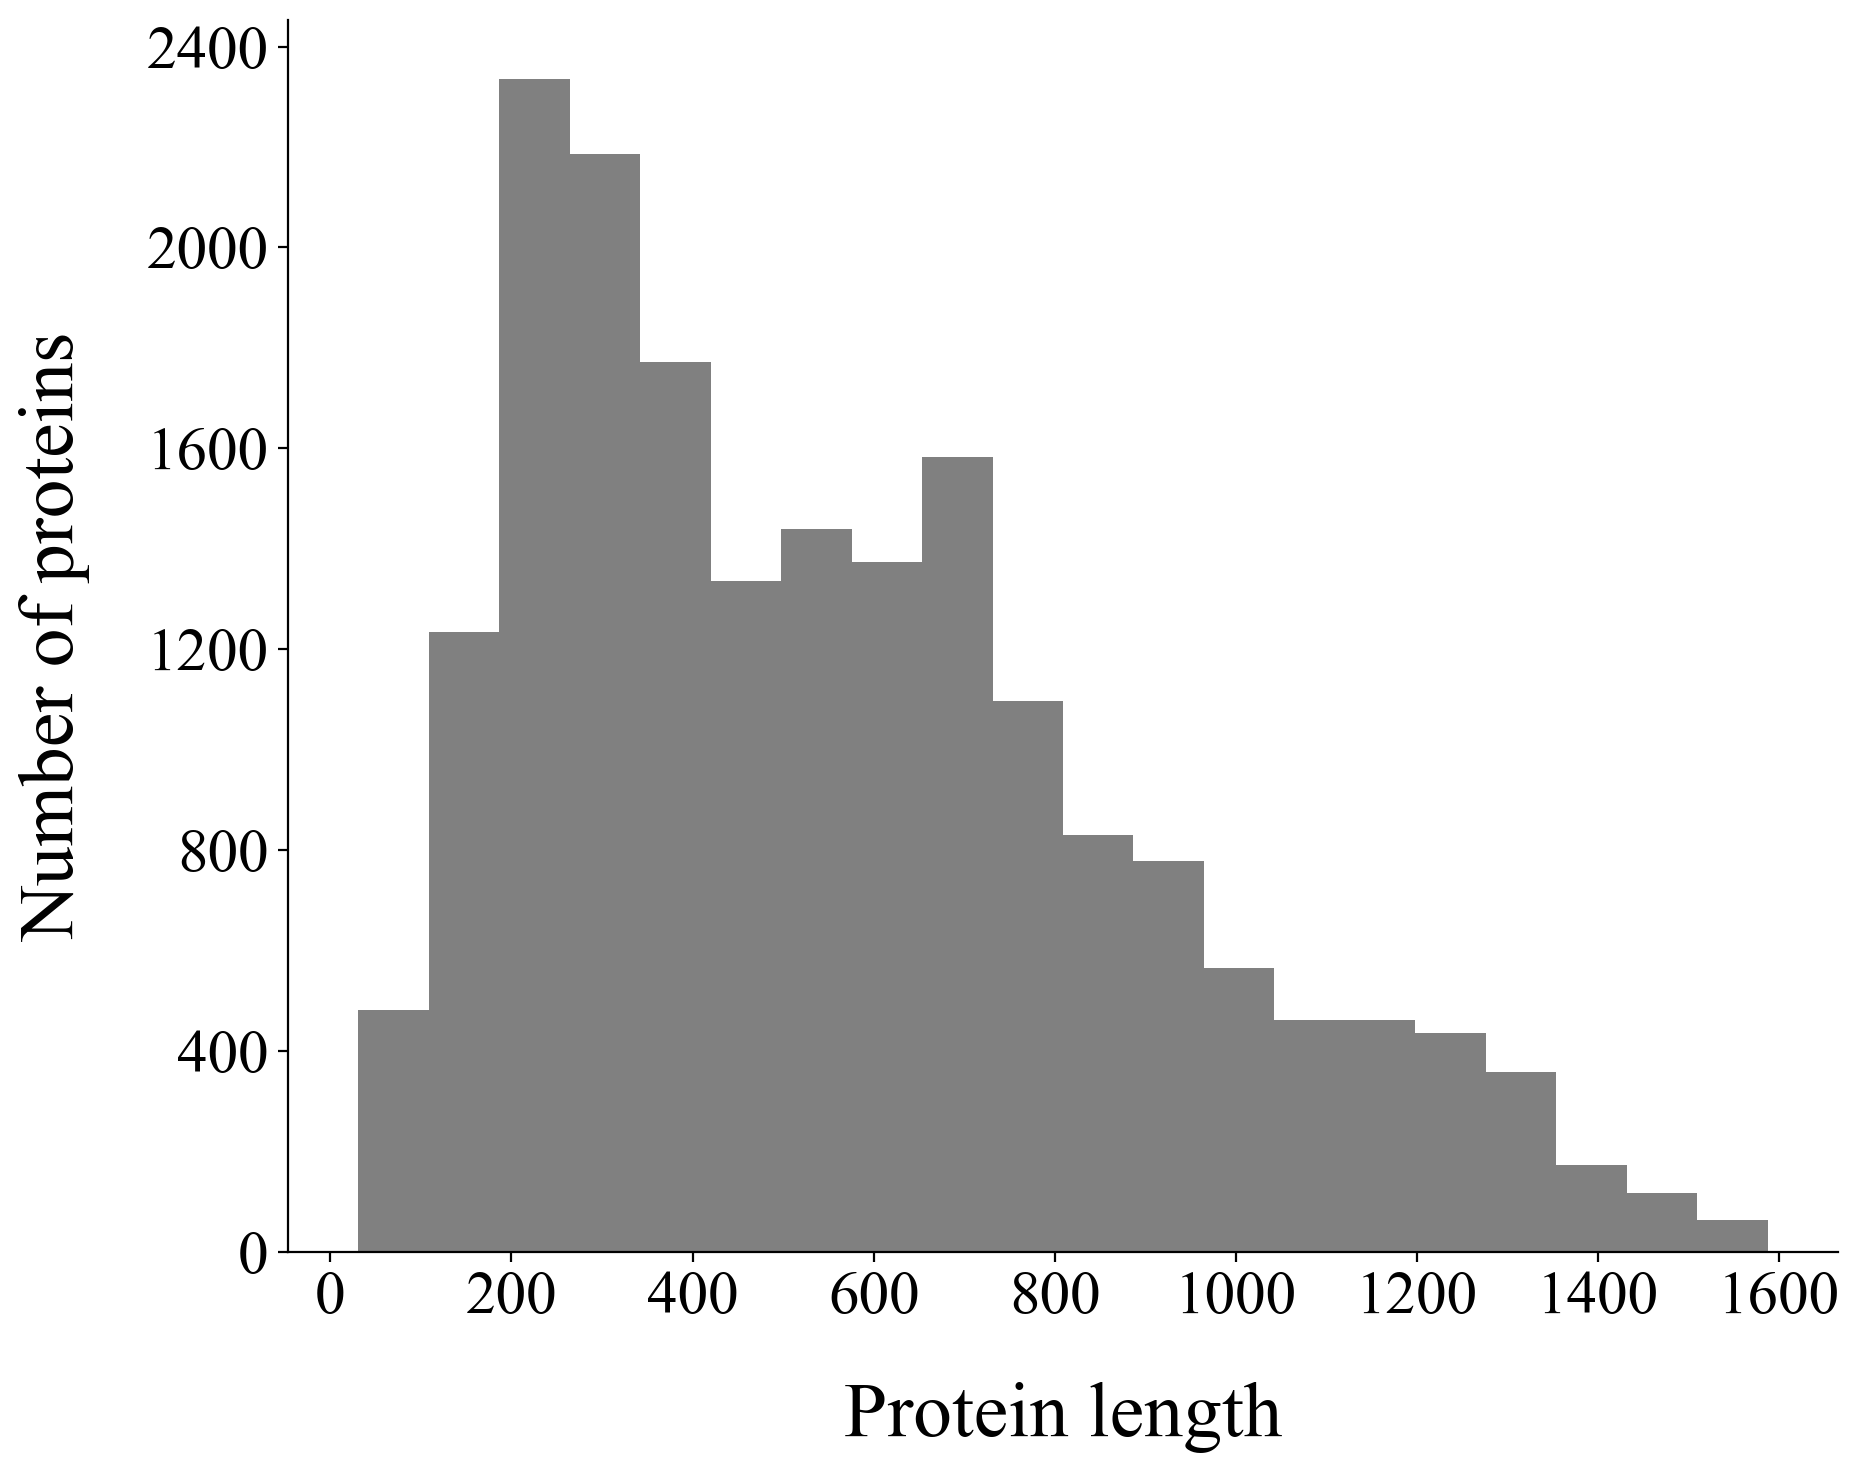

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 22

fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
plt.hist(rbp_lengths, bins=20, color="gray")
plt.yticks(np.arange(0, 2501, 400))
plt.xticks(np.arange(0, 1601, 200))
plt.xlabel("Protein length", labelpad=20, fontsize=28)
plt.ylabel("Number of proteins", labelpad=20, fontsize=28)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
plt.show()

Compute some descriptive statistics.

In [8]:
print("Mean:", mean(rbp_lengths))
print("Median:", median(rbp_lengths))

Mean: 565.2789686075154
Median: 507


### Compute protein length per ESKAPEE genus

In [9]:
for similarity in range(100, 39, -10):
    for model in models:
        model = model.lower()
        df, df_all, protein_clusters = util.filter_proteins_based_on_struct_and_seq_sim(
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_{model}.csv",
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_saprot_relaxed_r3.csv",
            f"{constants.INPHARED}/{constants.FASTA}/complete-struct-{similarity}.fasta.clstr",
        )

    break

In [10]:
labels = [
    "enterococcus",
    "staphylococcus",
    "klebsiella",
    "acinetobacter",
    "pseudomonas",
    "enterobacter",
    "escherichia",
]

lengths_dict = defaultdict(list)
proteins_dict = defaultdict(list)

for label in labels:
    df_label = df.loc[df["Host"] == label]
    proteins_dict[label] = df_label["Protein Sequence"].values

In [11]:
for label in labels:
    for protein in tqdm(proteins_dict[label]):
        lengths_dict[label].append(len(protein))

100%|█████████████████████████████████████████████████████████████████████████| 3464/3464 [00:00<00:00, 1349156.75it/s]


Plot the distribution of the lengths.

enterococcus


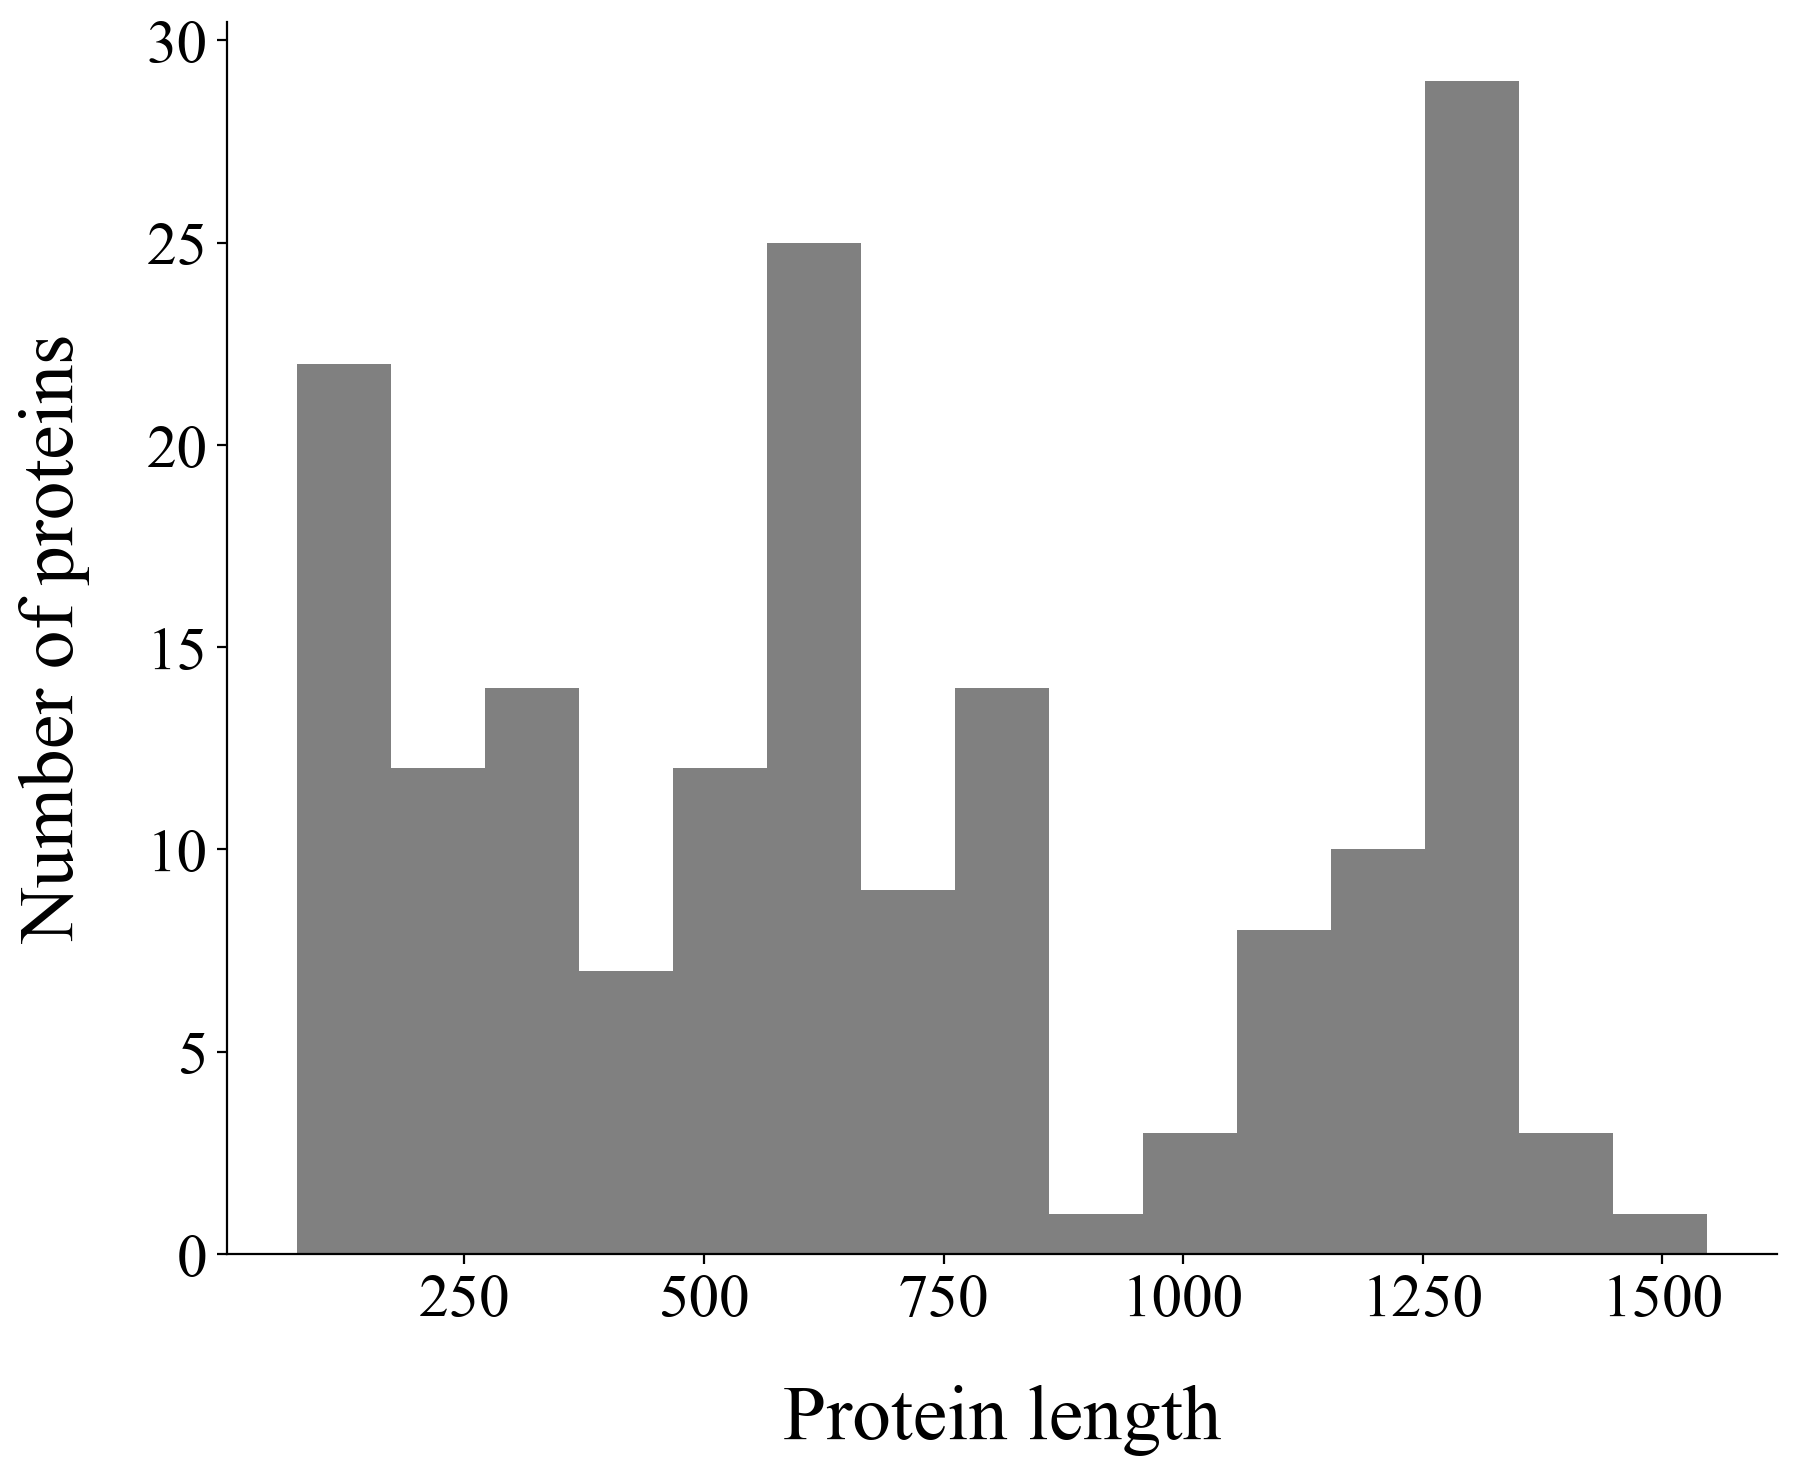

staphylococcus


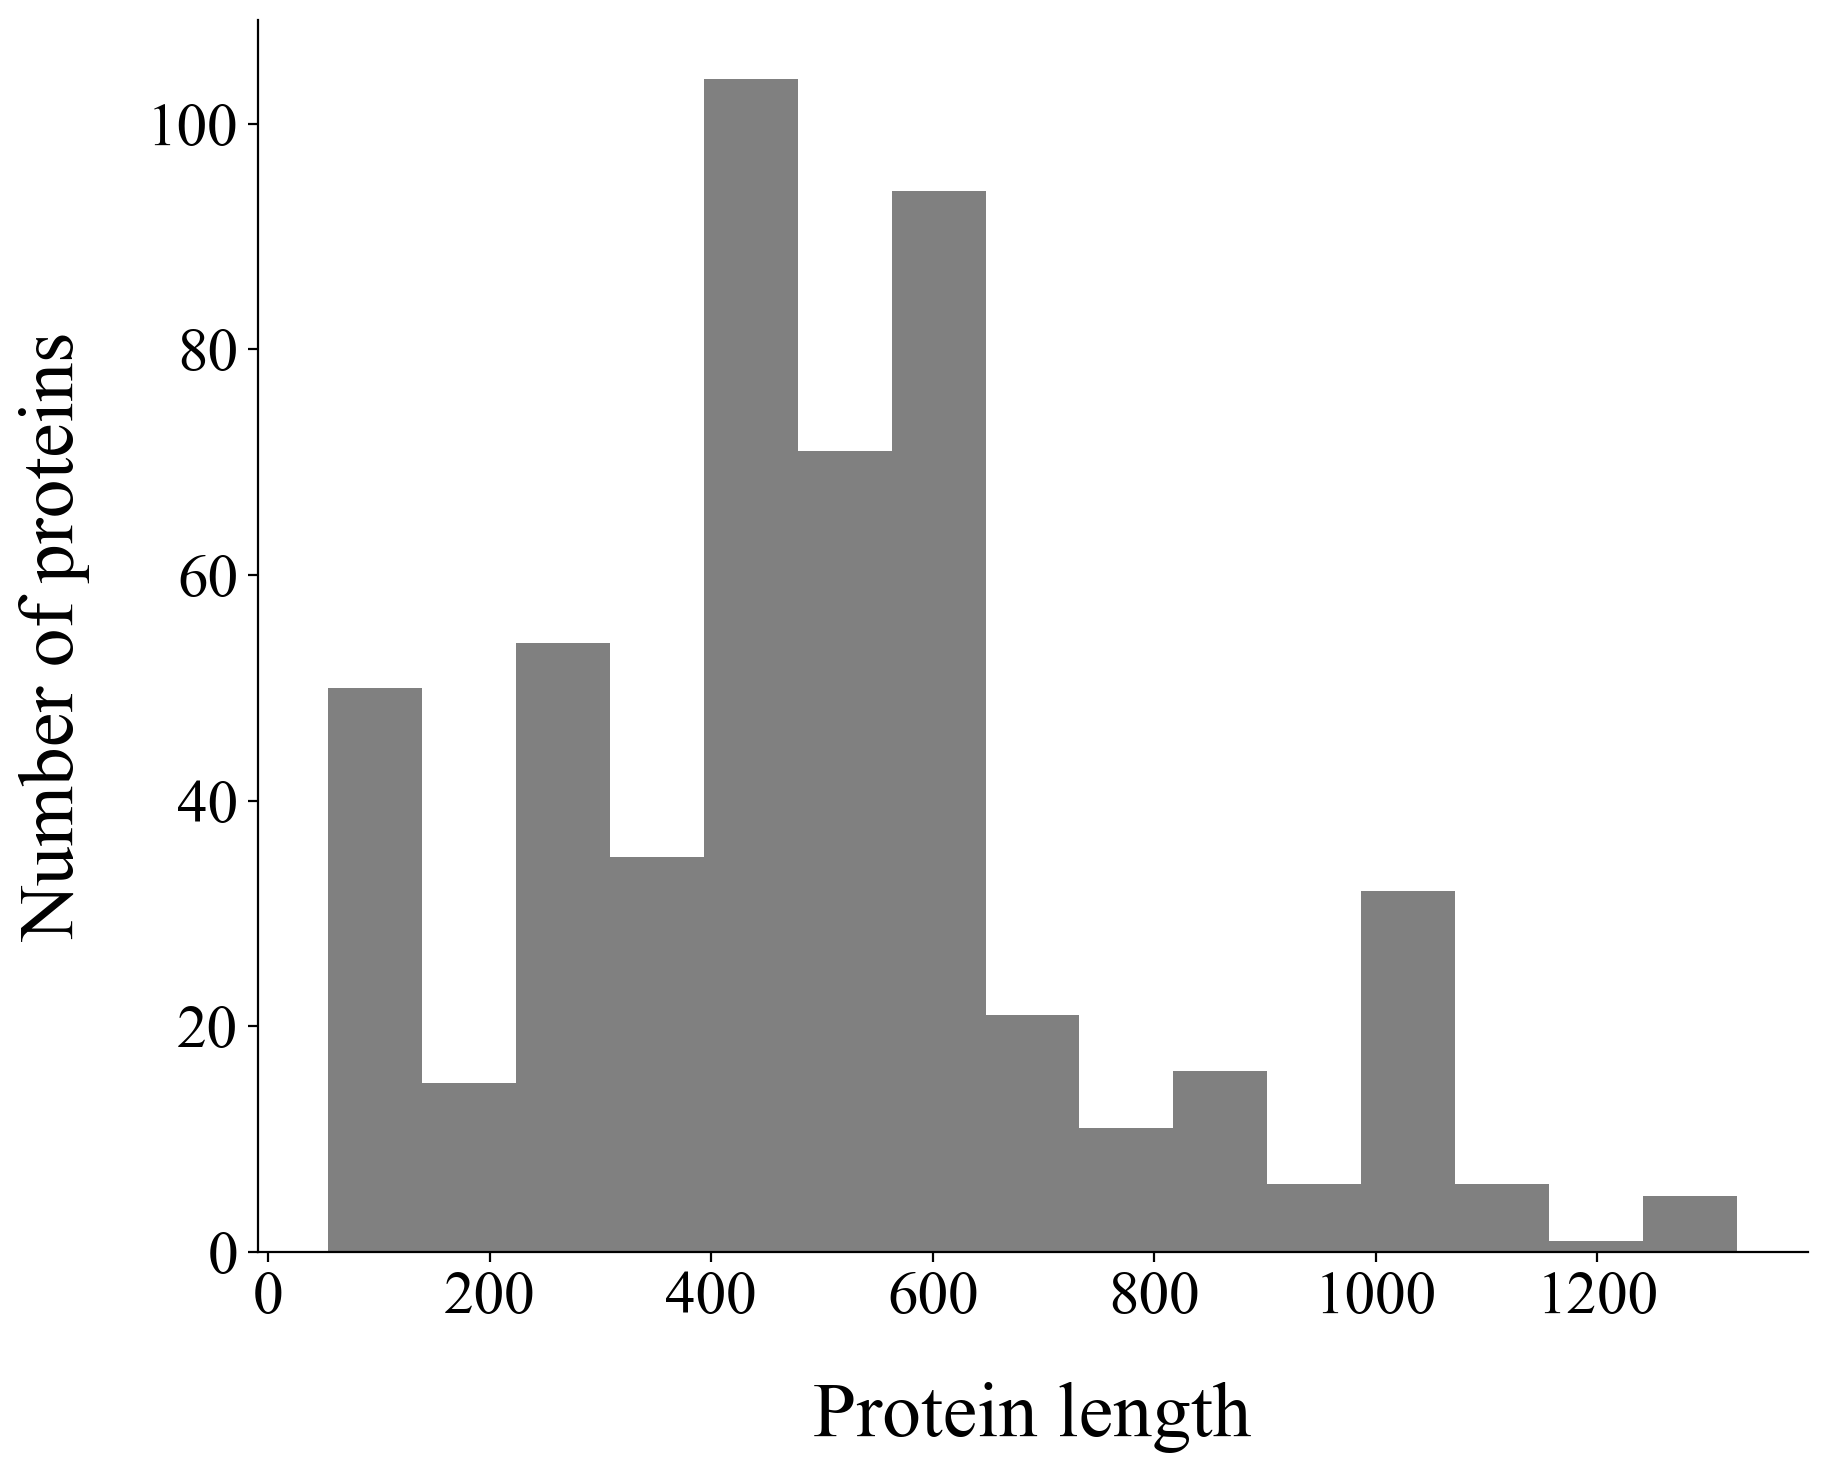

klebsiella


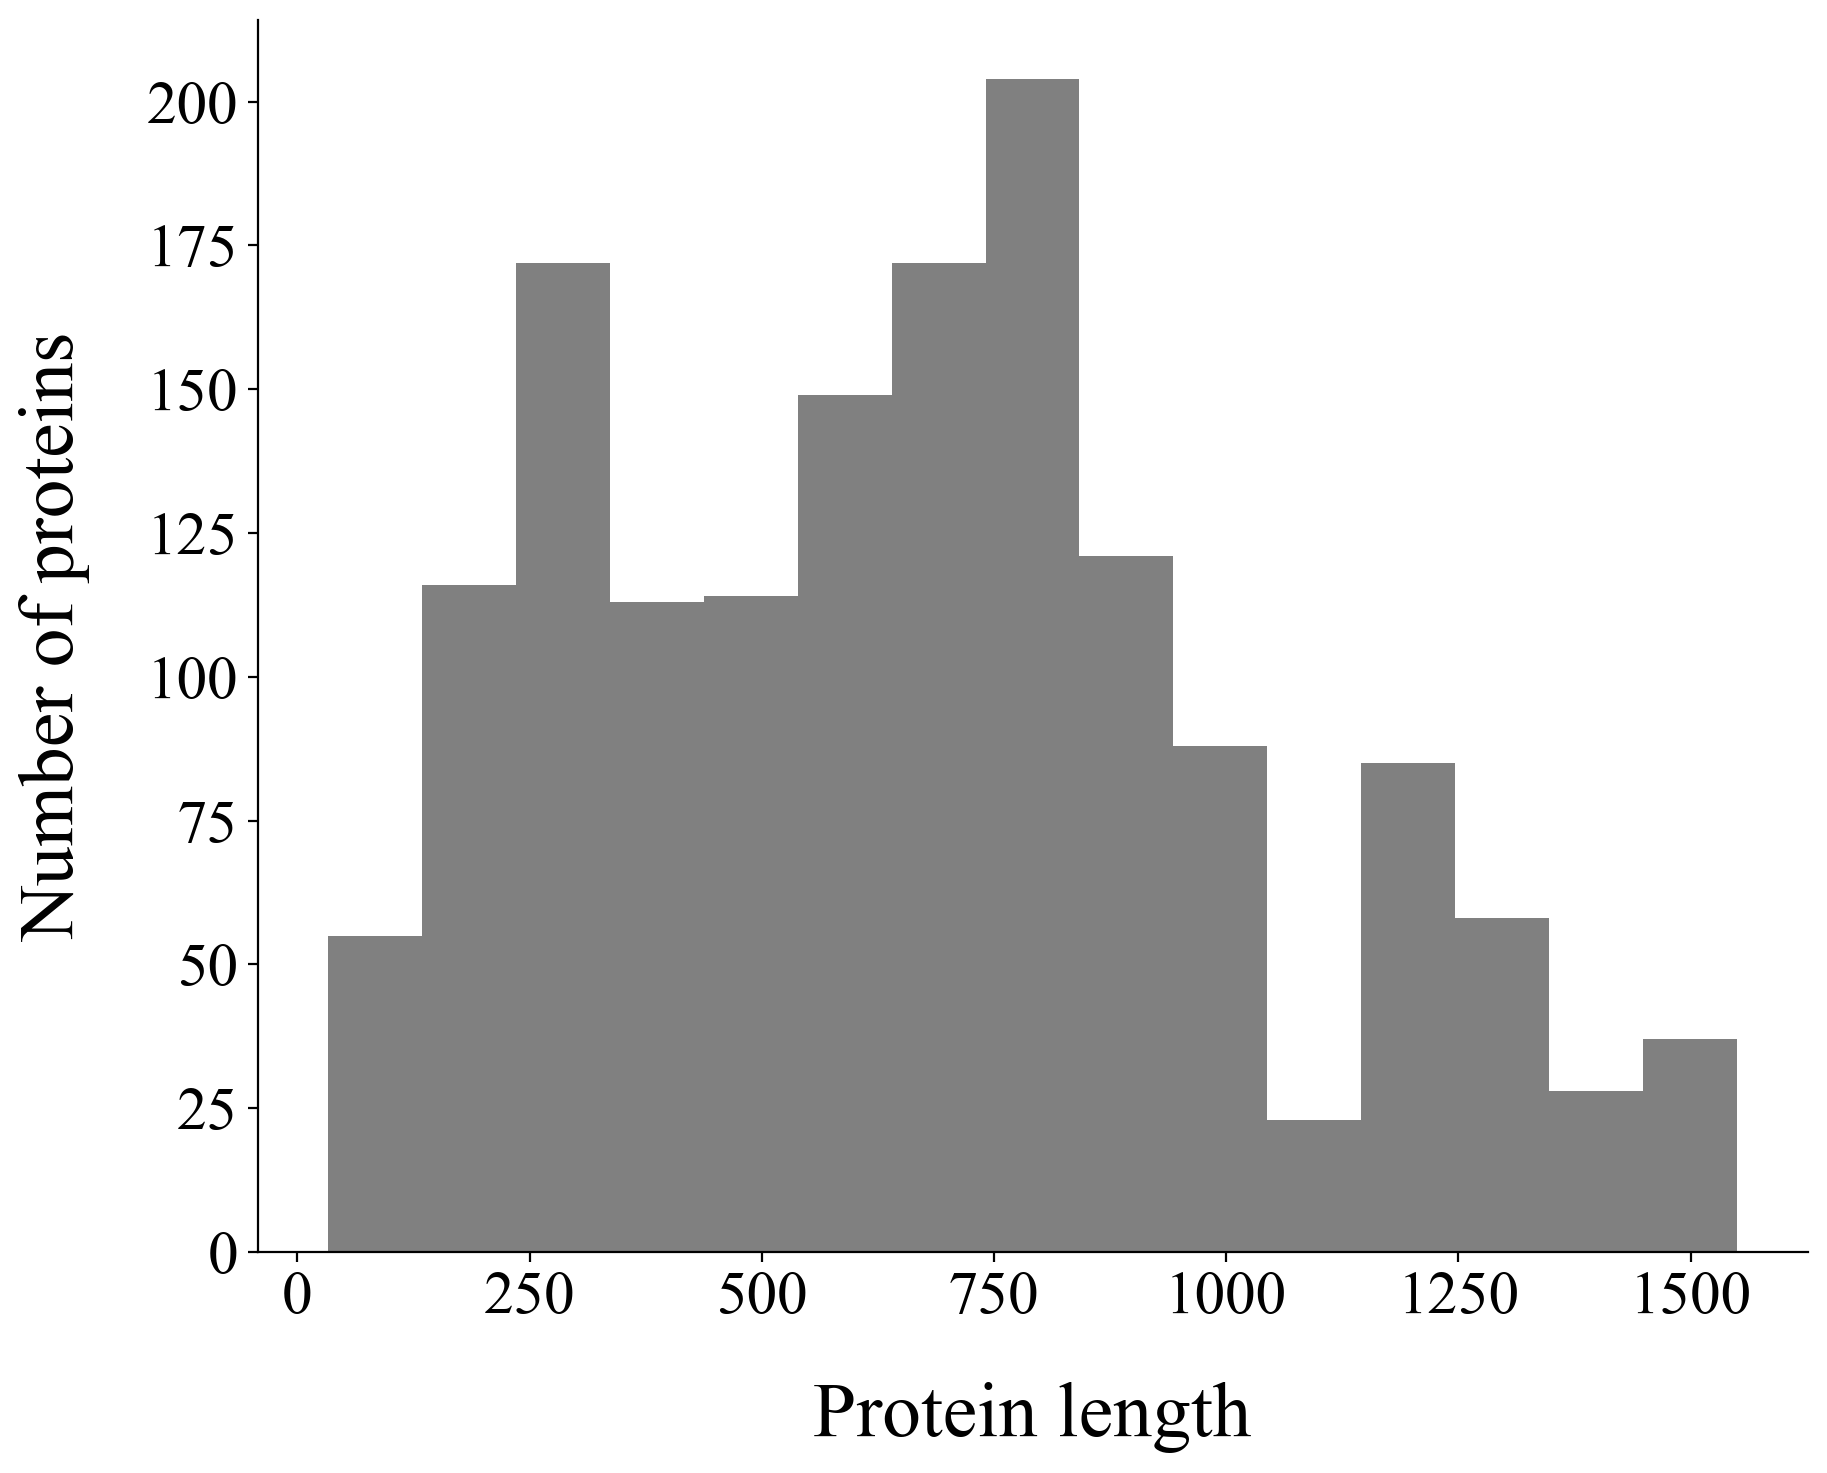

acinetobacter


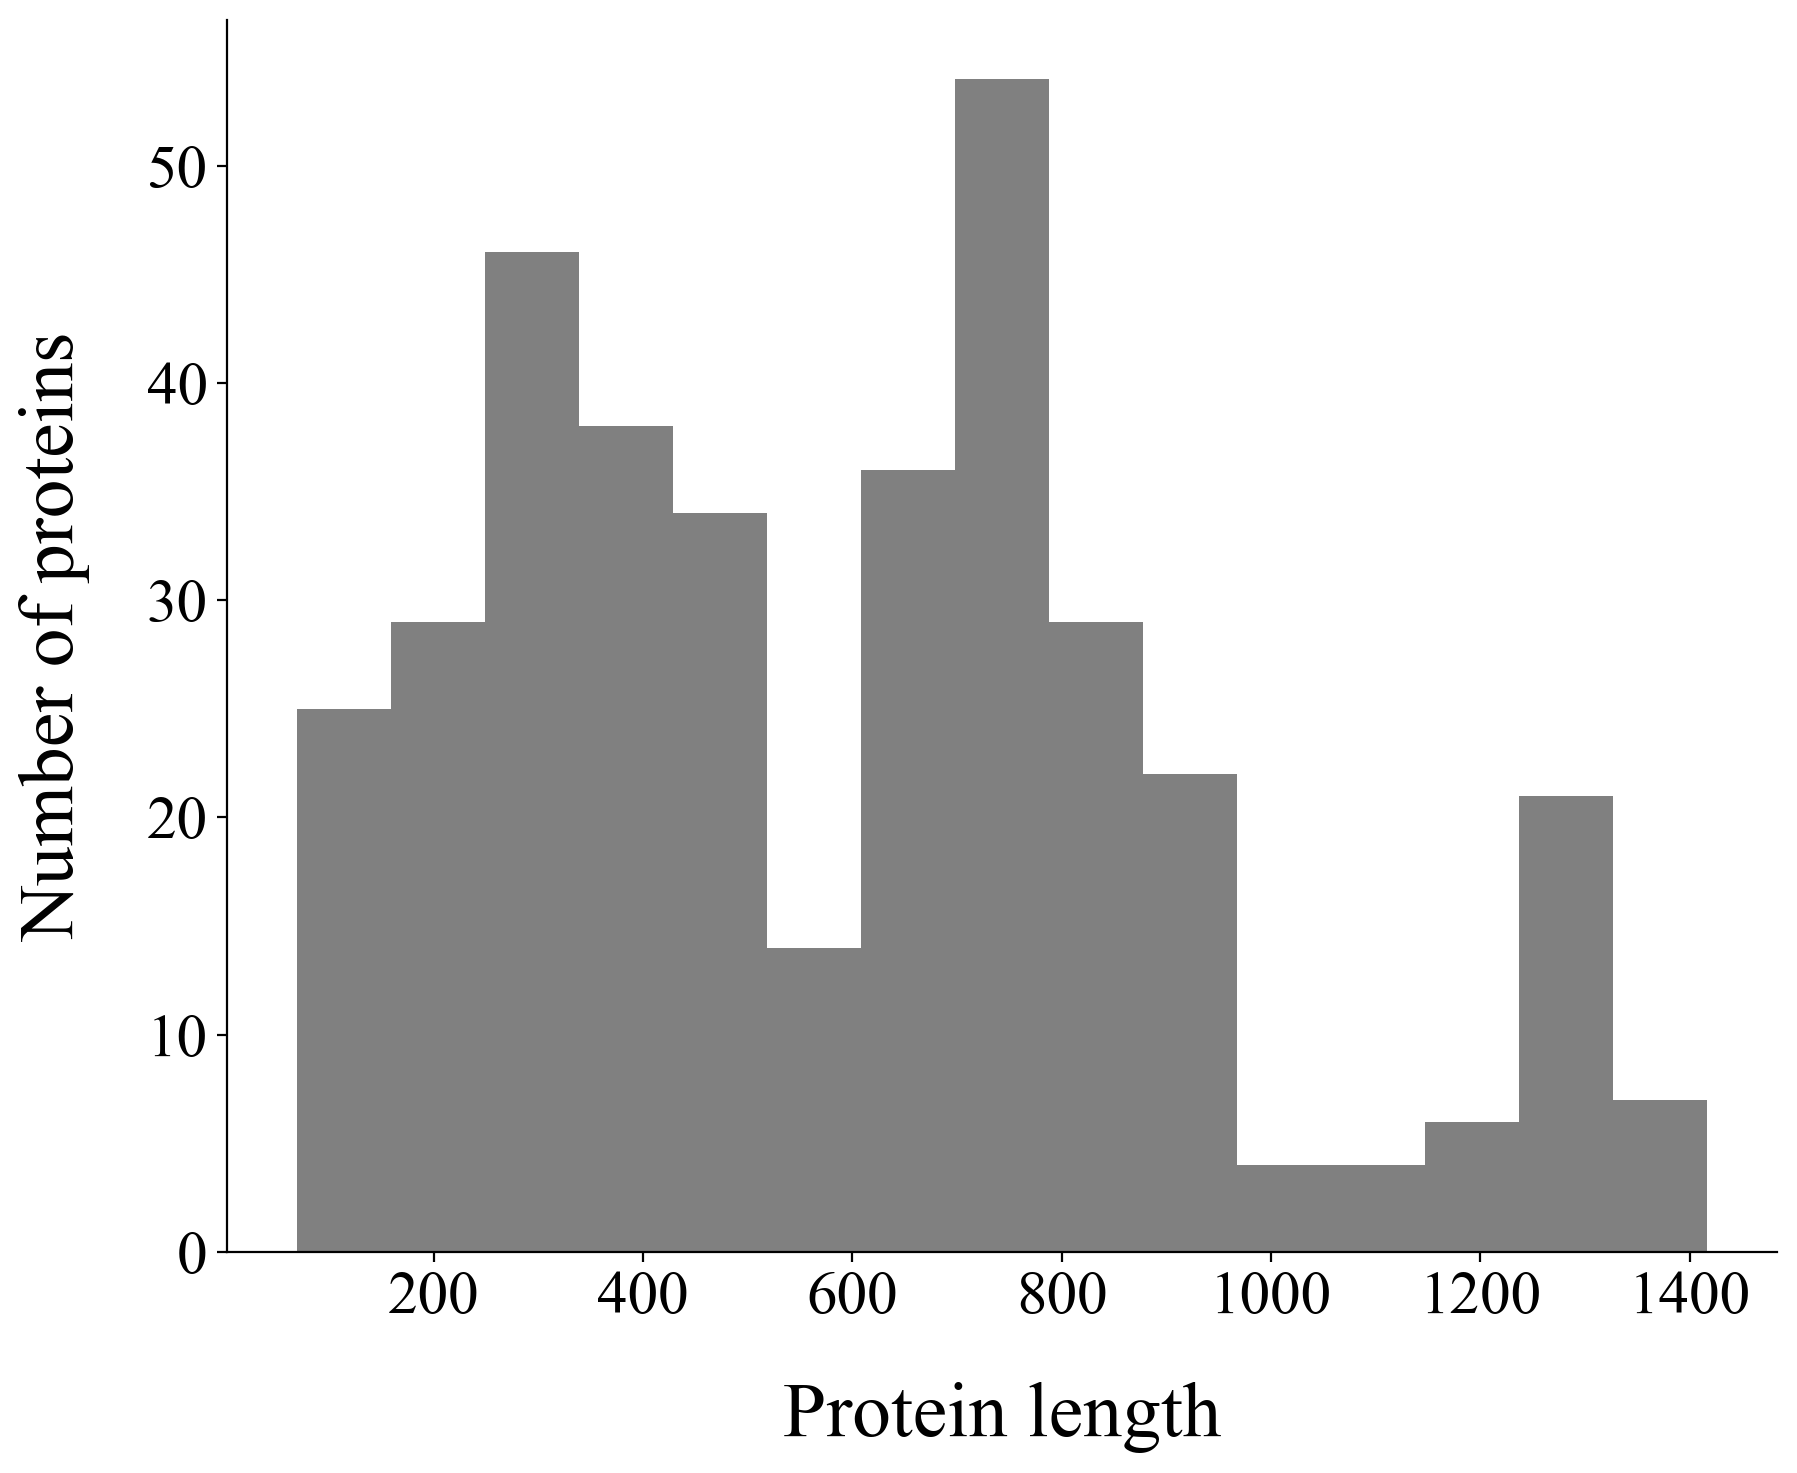

pseudomonas


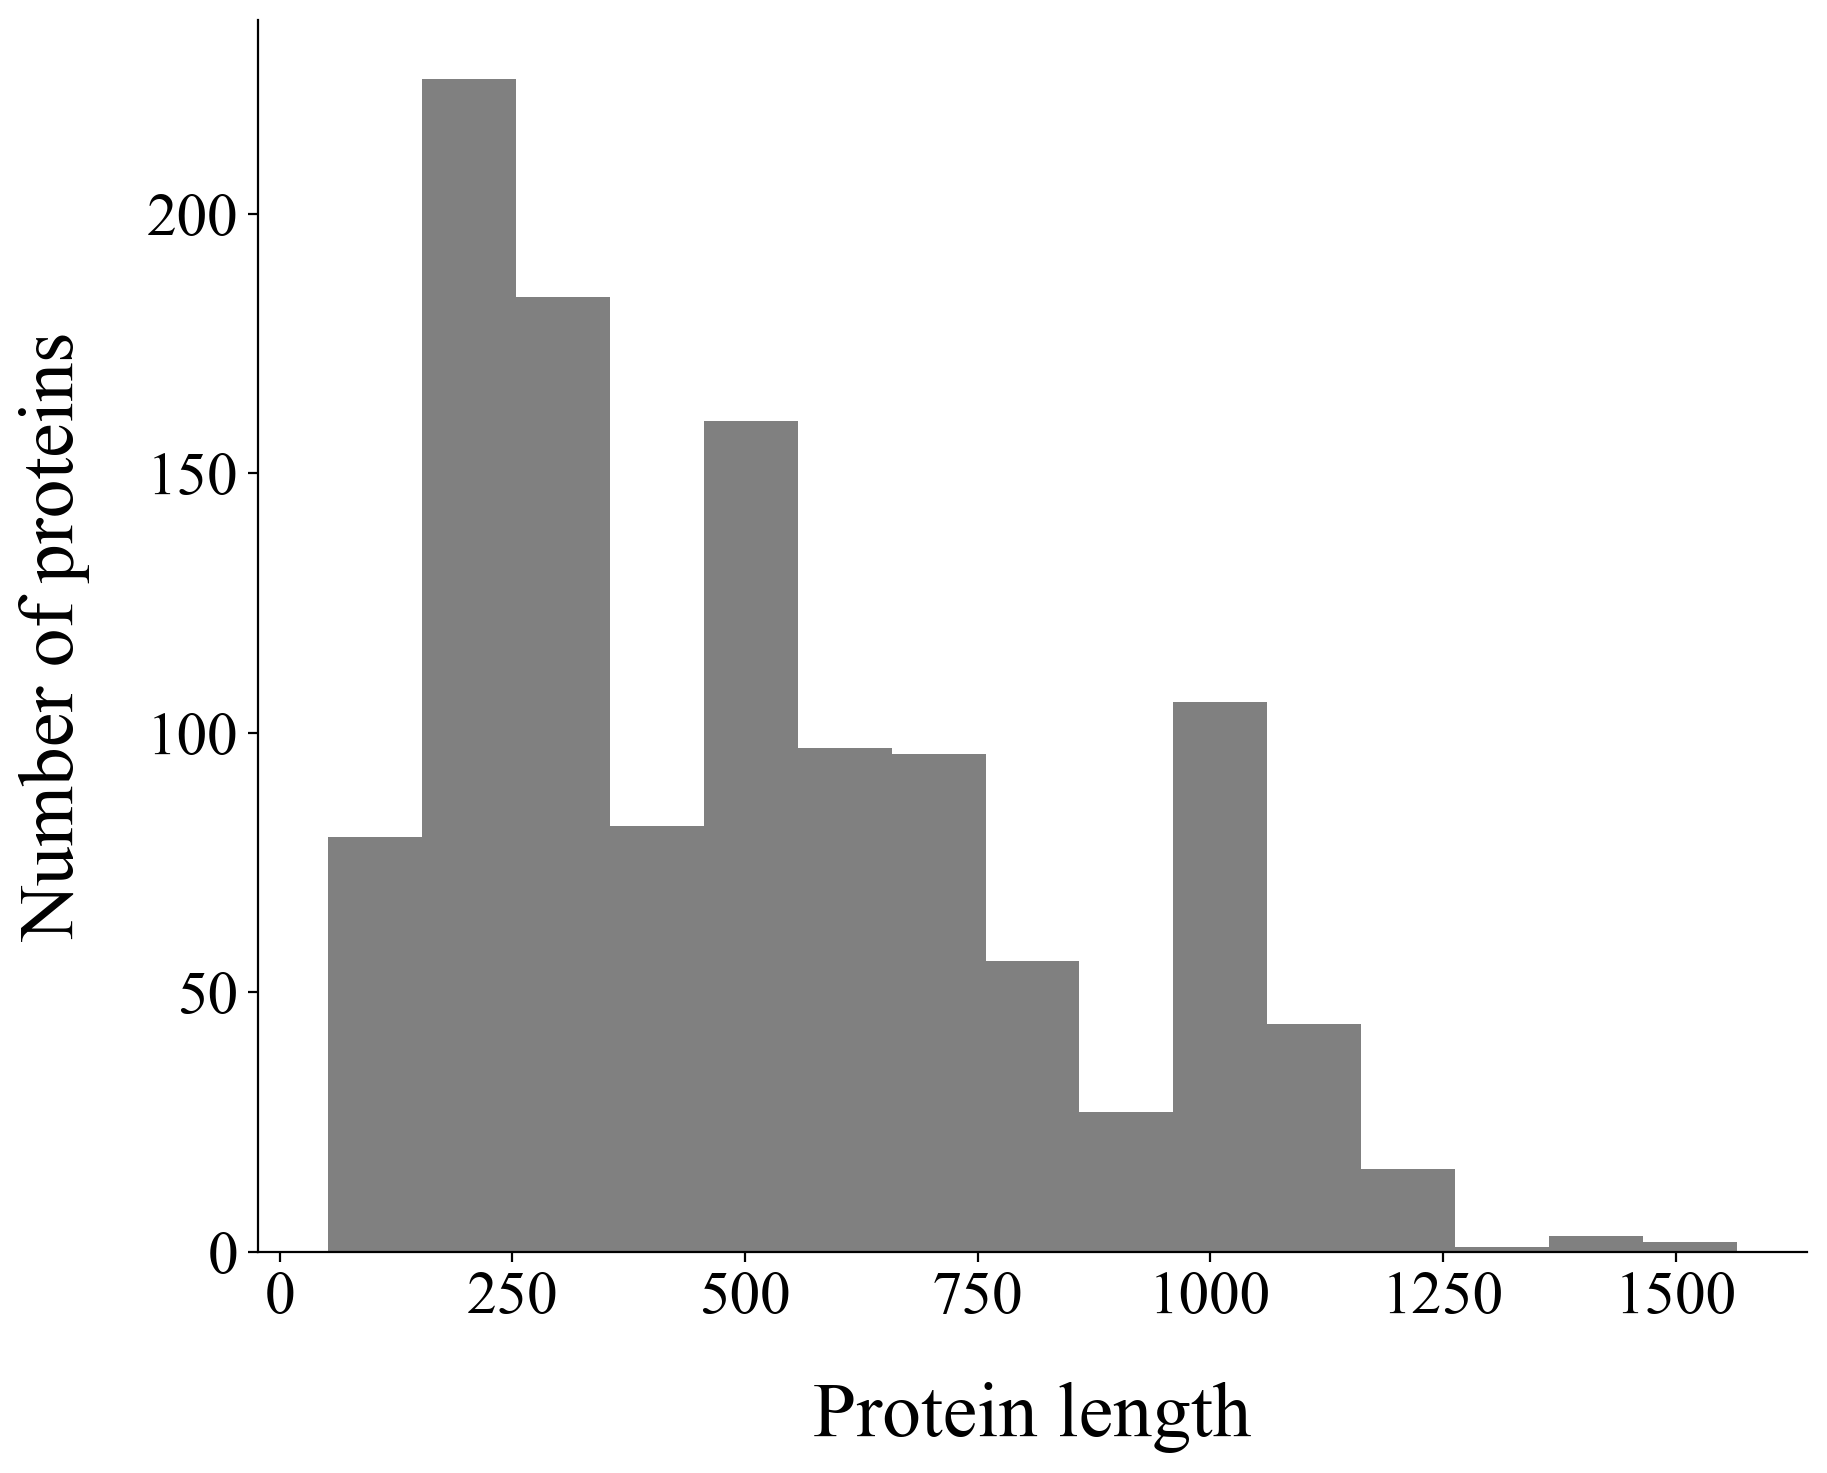

enterobacter


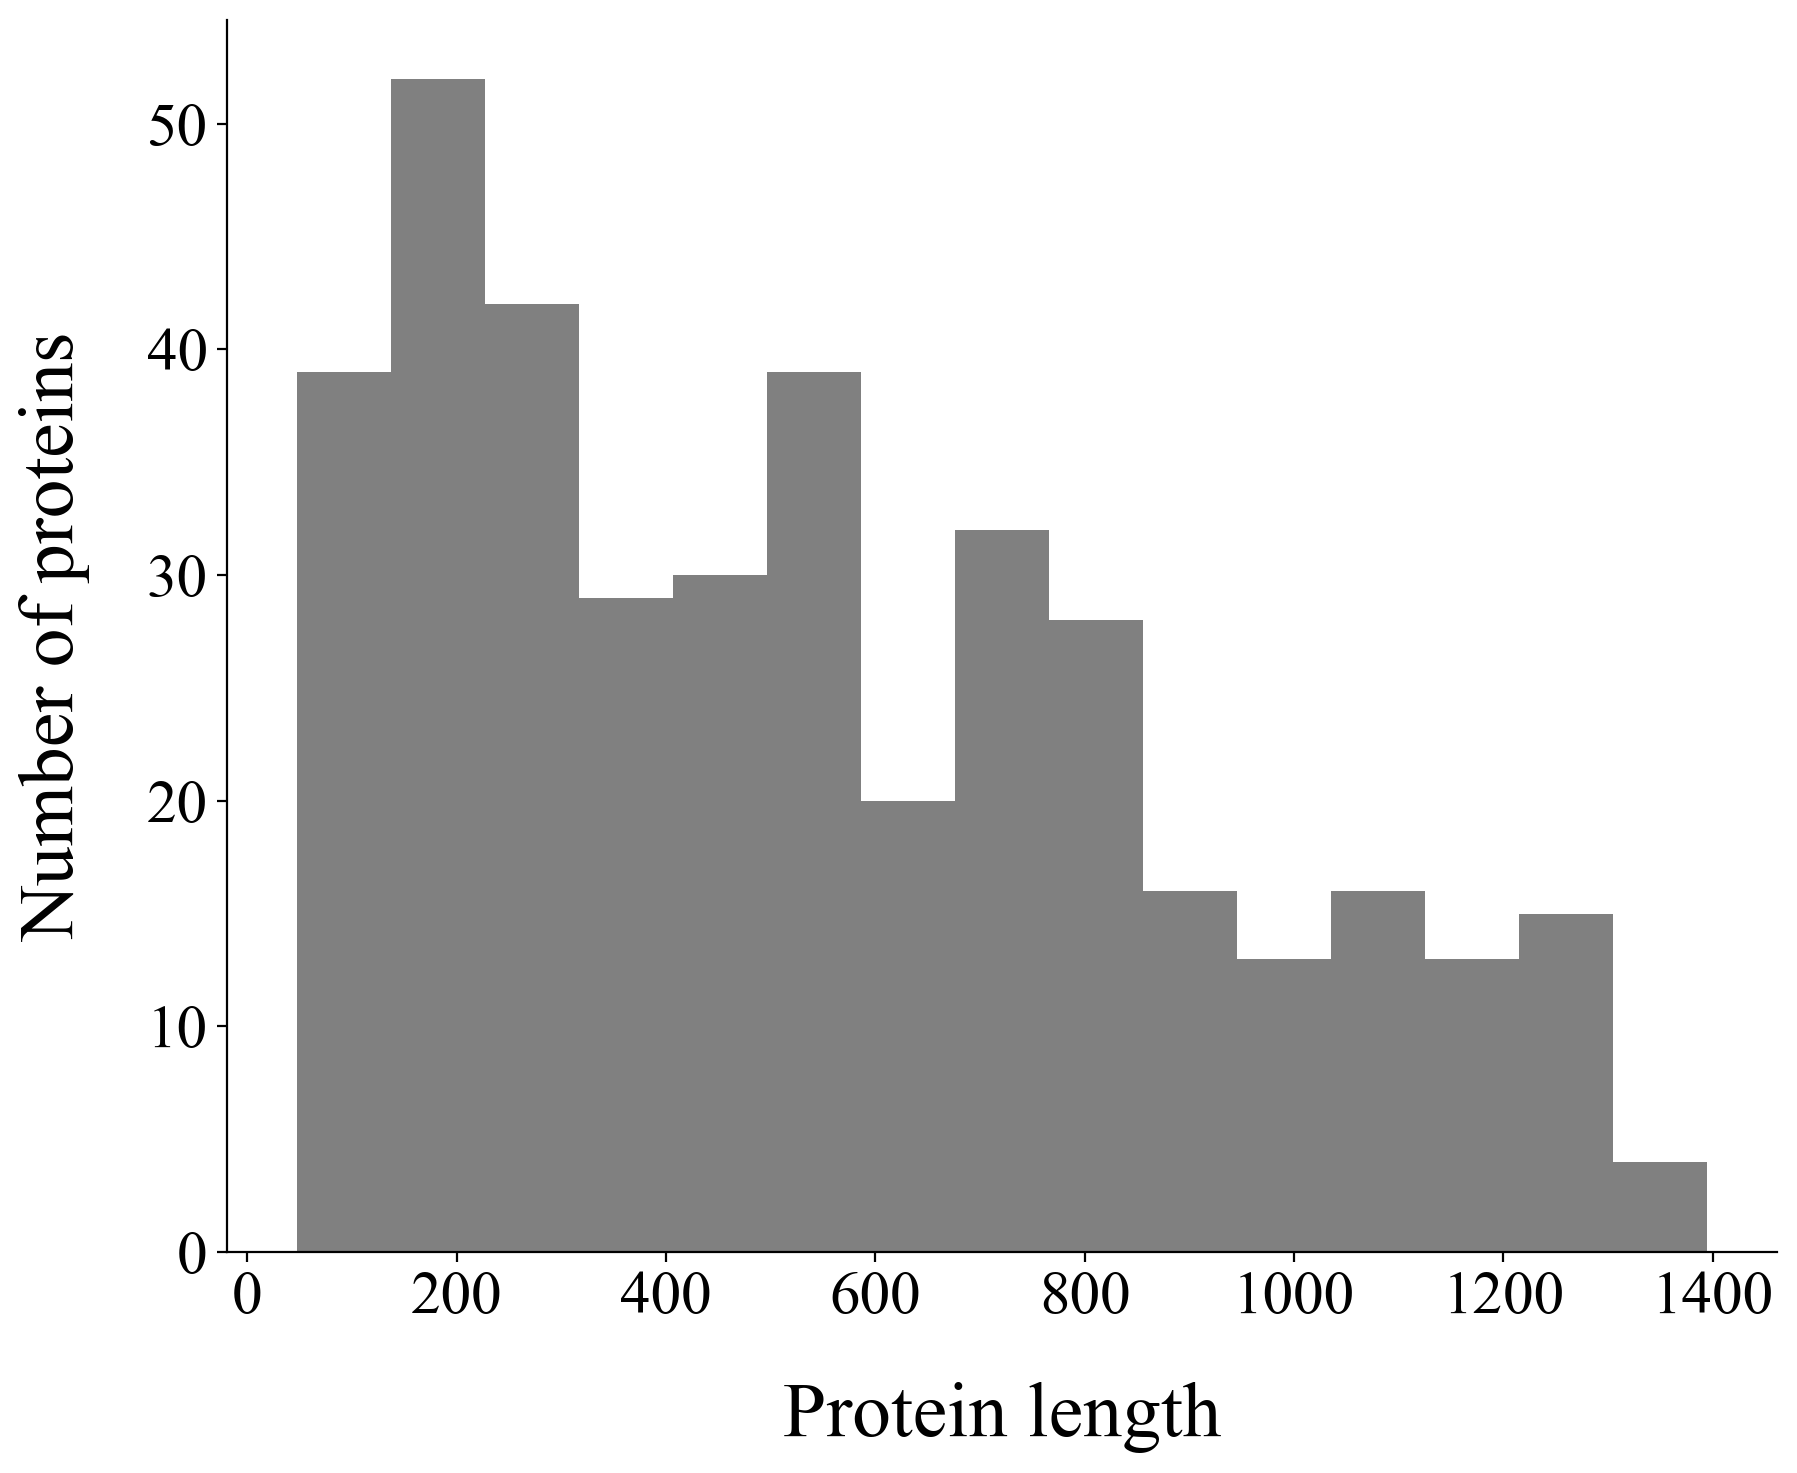

escherichia


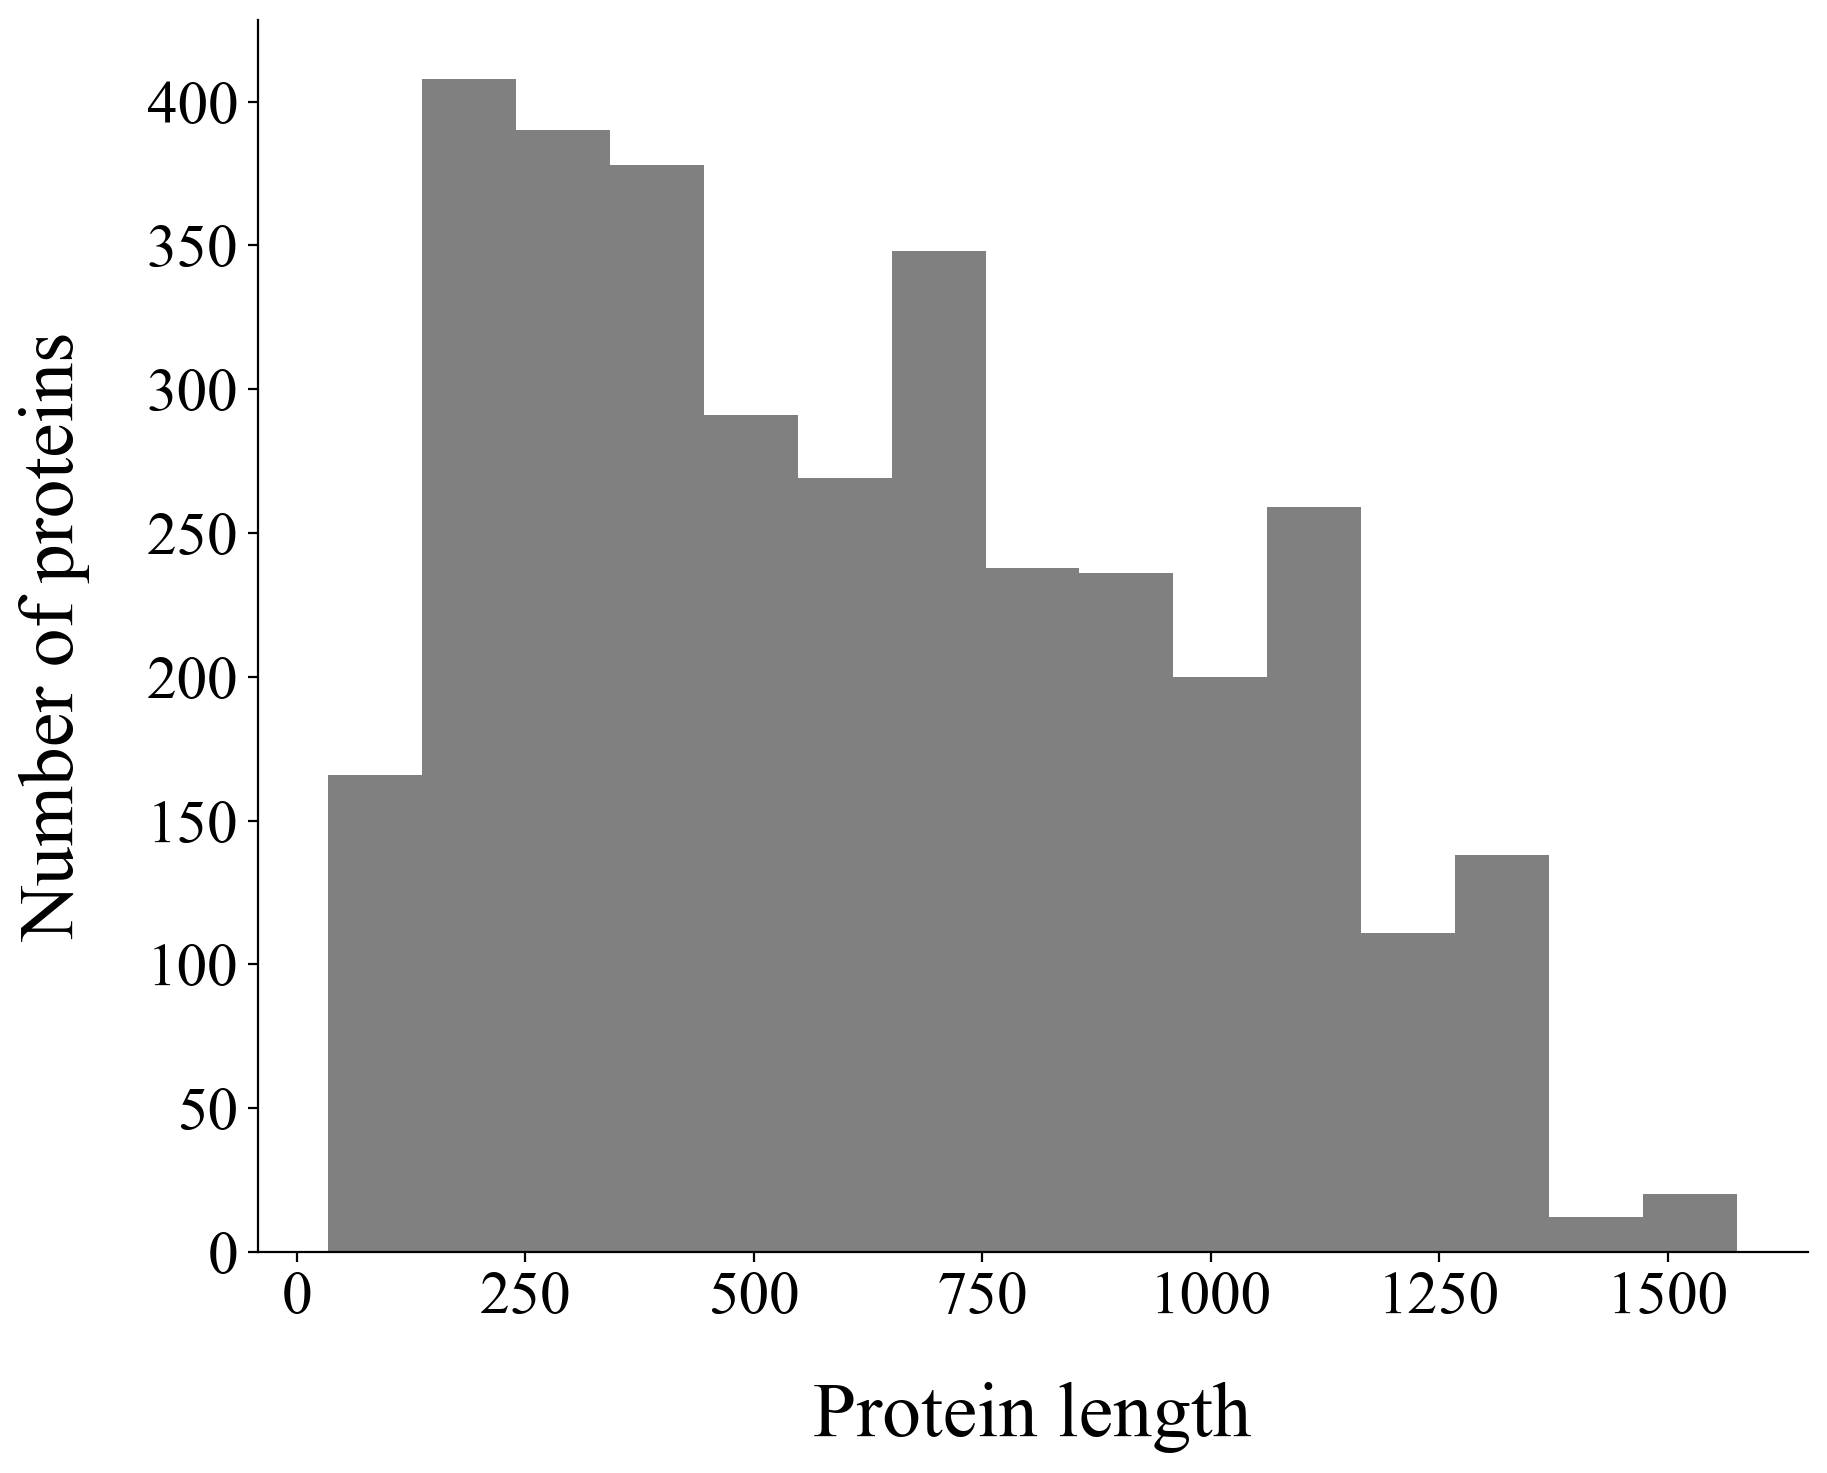

In [12]:
for label in labels:
    print(label)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 22

    fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
    plt.hist(lengths_dict[label], bins=15, color="gray")
    plt.xlabel("Protein length", labelpad=20, fontsize=28)
    plt.ylabel("Number of proteins", labelpad=20, fontsize=28)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    plt.show()

Compute some descriptive statistics.

In [13]:
for genus, length in lengths_dict.items():
    print(genus)
    print("Mean:", mean(length))
    print("Median:", median(length))
    print("=========")

enterococcus
Mean: 704.4411764705883
Median: 619.5
staphylococcus
Mean: 510.2514395393474
Median: 481
klebsiella
Mean: 671.3791530944626
Median: 658
acinetobacter
Mean: 599.3875338753387
Median: 607
pseudomonas
Mean: 509.49152542372883
Median: 476.5
enterobacter
Mean: 545.0618556701031
Median: 512.0
escherichia
Mean: 622.0184757505774
Median: 581.0


Print the number of samples per genus.

In [14]:
for genus, length in lengths_dict.items():
    print(genus)
    print(len(length))
    print("=========")

enterococcus
170
staphylococcus
521
klebsiella
1535
acinetobacter
369
pseudomonas
1180
enterobacter
388
escherichia
3464


<hr>

## Part III: ColabFold confidence scores (pLDDT scores)

Get the pLDDT scores of the (non-redundant) proteins in our dataset.

In [15]:
PDB_PATH = f"{constants.INPHARED}/{constants.STRUCTURE}/pdb"


def get_average_plddt(file, relaxed=False):
    with open(file) as f:
        if not relaxed:
            next(f)

        plddt_vals = []
        for line in f:
            vals = re.split("\s+", line.strip())
            try:
                plddt_vals.append(float(vals[-2]))
            except ValueError:
                break

        return mean(plddt_vals)

In [16]:
for similarity in range(100, 39, -10):
    for model in models:
        model = model.lower()
        df, df_all, protein_clusters = util.filter_proteins_based_on_struct_and_seq_sim(
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_{model}.csv",
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_saprot_relaxed_r3.csv",
            f"{constants.INPHARED}/{constants.FASTA}/complete-struct-{similarity}.fasta.clstr",
        )

    break

In [17]:
proteins = df["Protein ID"].values
plddt = []

for protein in tqdm(proteins):
    plddt.append(
        get_average_plddt(f"{PDB_PATH}/{protein}_relaxed.r3.pdb", relaxed=True)
    )

100%|██████████████████████████████████████████████████████████████████████████| 19081/19081 [1:03:20<00:00,  5.02it/s]


In [18]:
if not os.path.exists(constants.TEMP_EDA):
    os.makedirs(constants.TEMP_EDA)

with open(f"{constants.TEMP_EDA}/plddt.pickle", "wb") as f:
    pickle.dump(plddt, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"{constants.TEMP_EDA}/plddt.pickle", "rb") as f:
    plddt = pickle.load(f)

Plot the distribution of the pLDDT scores.

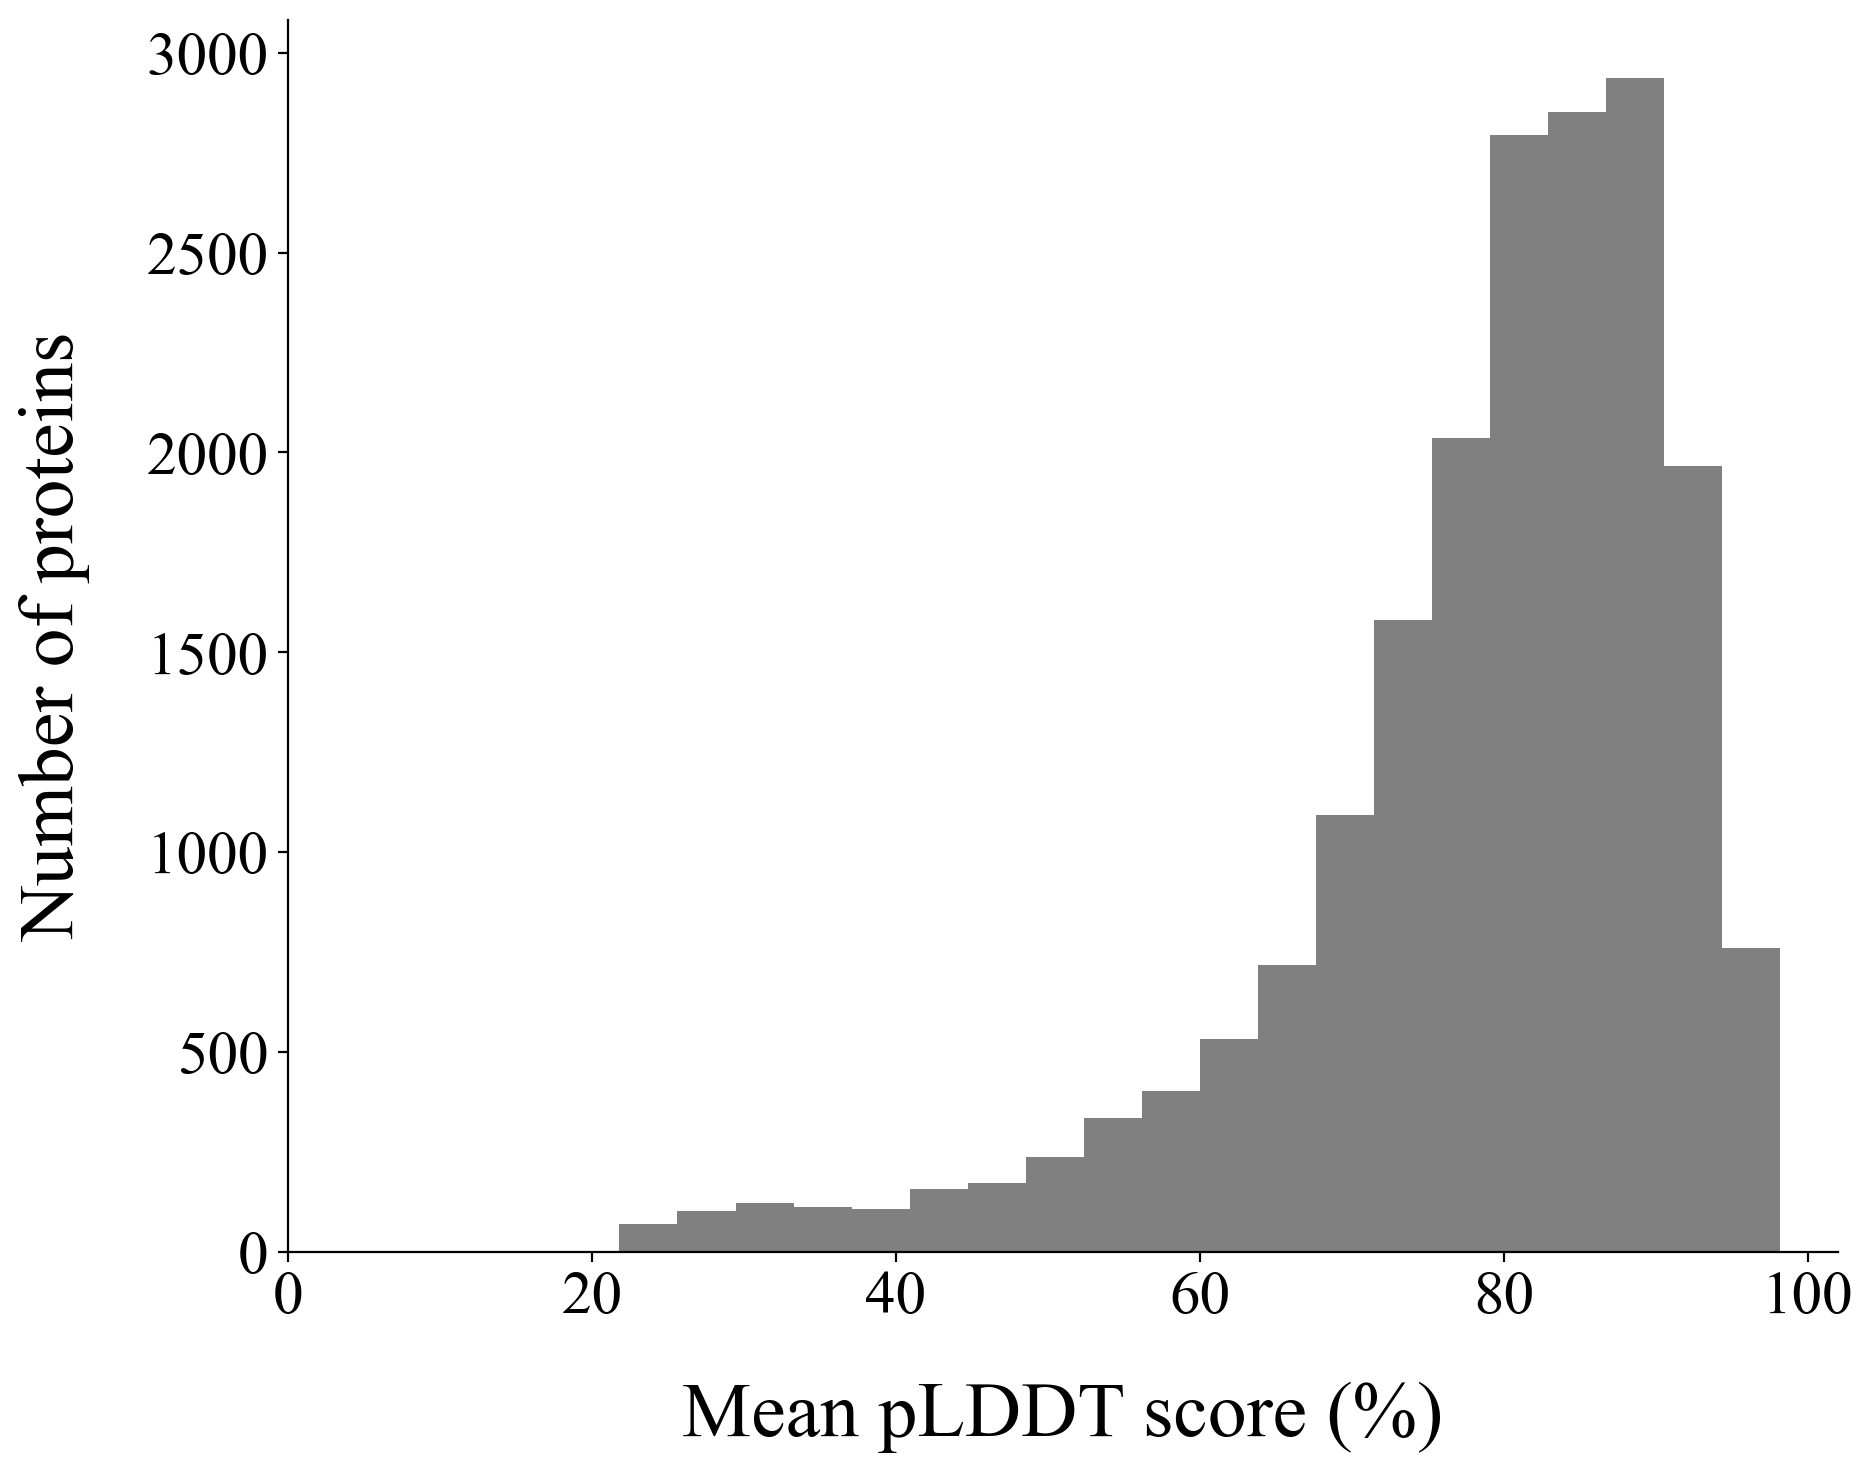

In [19]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 22

fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
plt.hist(plddt, bins=20, color="gray")
plt.xticks(np.arange(0, 101, 20))
plt.xlabel("Mean pLDDT score (%)", labelpad=20, fontsize=28)
plt.ylabel("Number of proteins", labelpad=20, fontsize=28)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)
plt.show()

Compute some descriptive statistics.

In [20]:
print("Mean:", mean(plddt))
print("Median:", median(plddt))

Mean: 78.4539942984293
Median: 81.68960936398251


### Compute pLDDT score per ESKAPEE genus

In [21]:
for similarity in range(100, 39, -10):
    for model in models:
        model = model.lower()
        df, df_all, protein_clusters = util.filter_proteins_based_on_struct_and_seq_sim(
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_{model}.csv",
            f"{constants.INPHARED}/{constants.CONSOLIDATED}/rbp_embeddings_saprot_relaxed_r3.csv",
            f"{constants.INPHARED}/{constants.FASTA}/complete-struct-{similarity}.fasta.clstr",
        )

    break

In [22]:
labels = [
    "enterococcus",
    "staphylococcus",
    "klebsiella",
    "acinetobacter",
    "pseudomonas",
    "enterobacter",
    "escherichia",
]

plddt_dict = defaultdict(list)
proteins_dict = defaultdict(list)

for label in labels:
    df_label = df.loc[df["Host"] == label]
    proteins_dict[label] = df_label["Protein ID"].values

In [23]:
for label in labels:
    for protein in tqdm(proteins_dict[label]):
        plddt_dict[label].append(
            get_average_plddt(f"{PDB_PATH}/{protein}_relaxed.r3.pdb", relaxed=True)
        )

100%|██████████████████████████████████████████████████████████████████████████████| 3464/3464 [06:35<00:00,  8.77it/s]


In [24]:
with open(f"{constants.TEMP_EDA}/plddt_eskapee.pickle", "wb") as f:
    pickle.dump(plddt_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"{constants.TEMP_EDA}/plddt_eskapee.pickle", "rb") as f:
    plddt_dict = pickle.load(f)

Plot the distribution of the pLDDT scores.

enterococcus


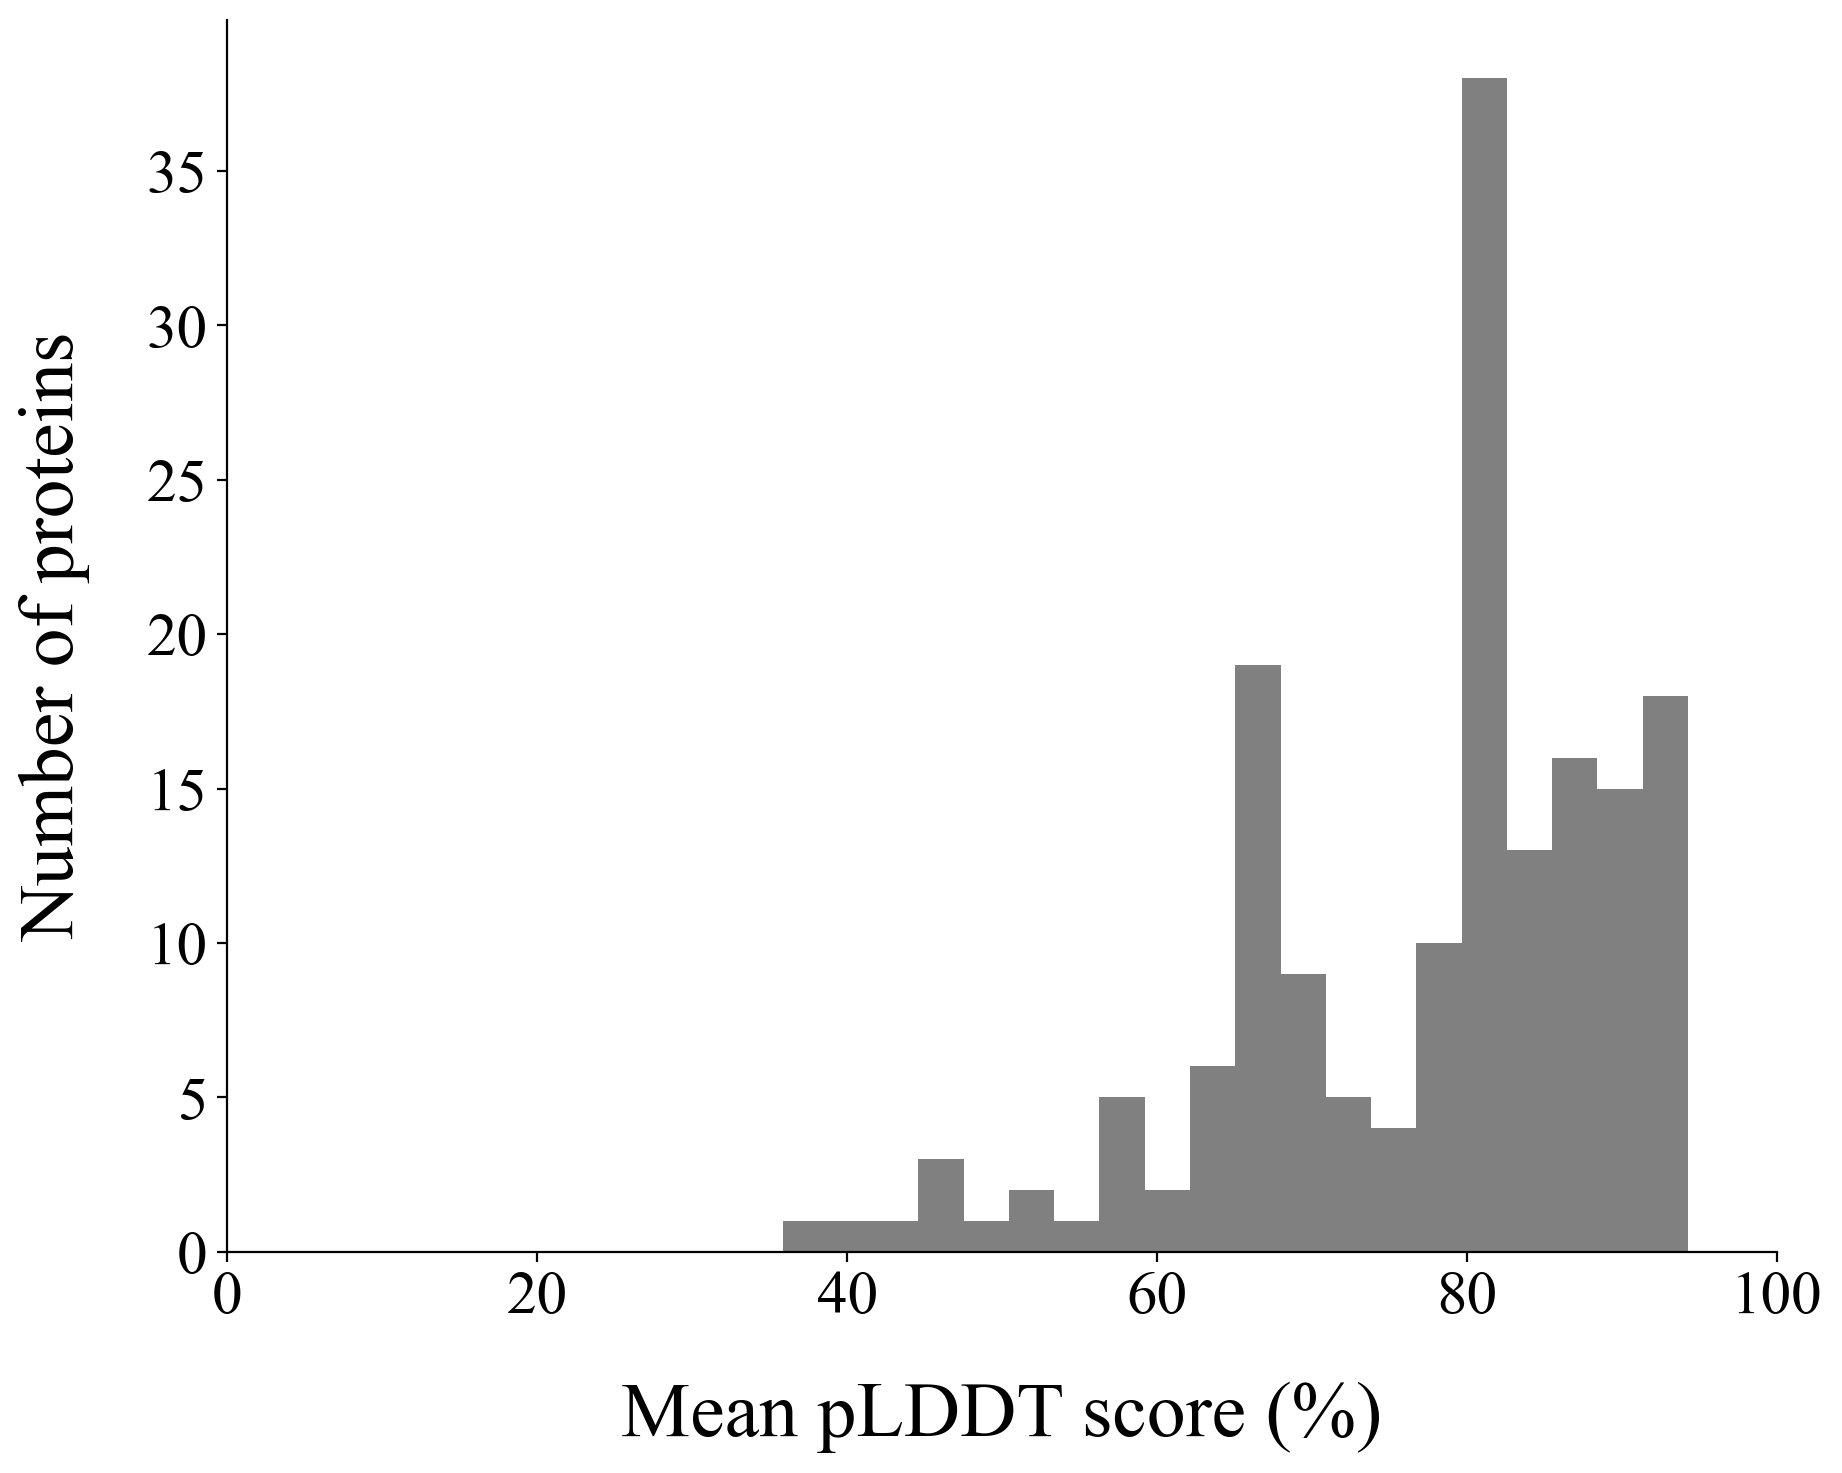

staphylococcus


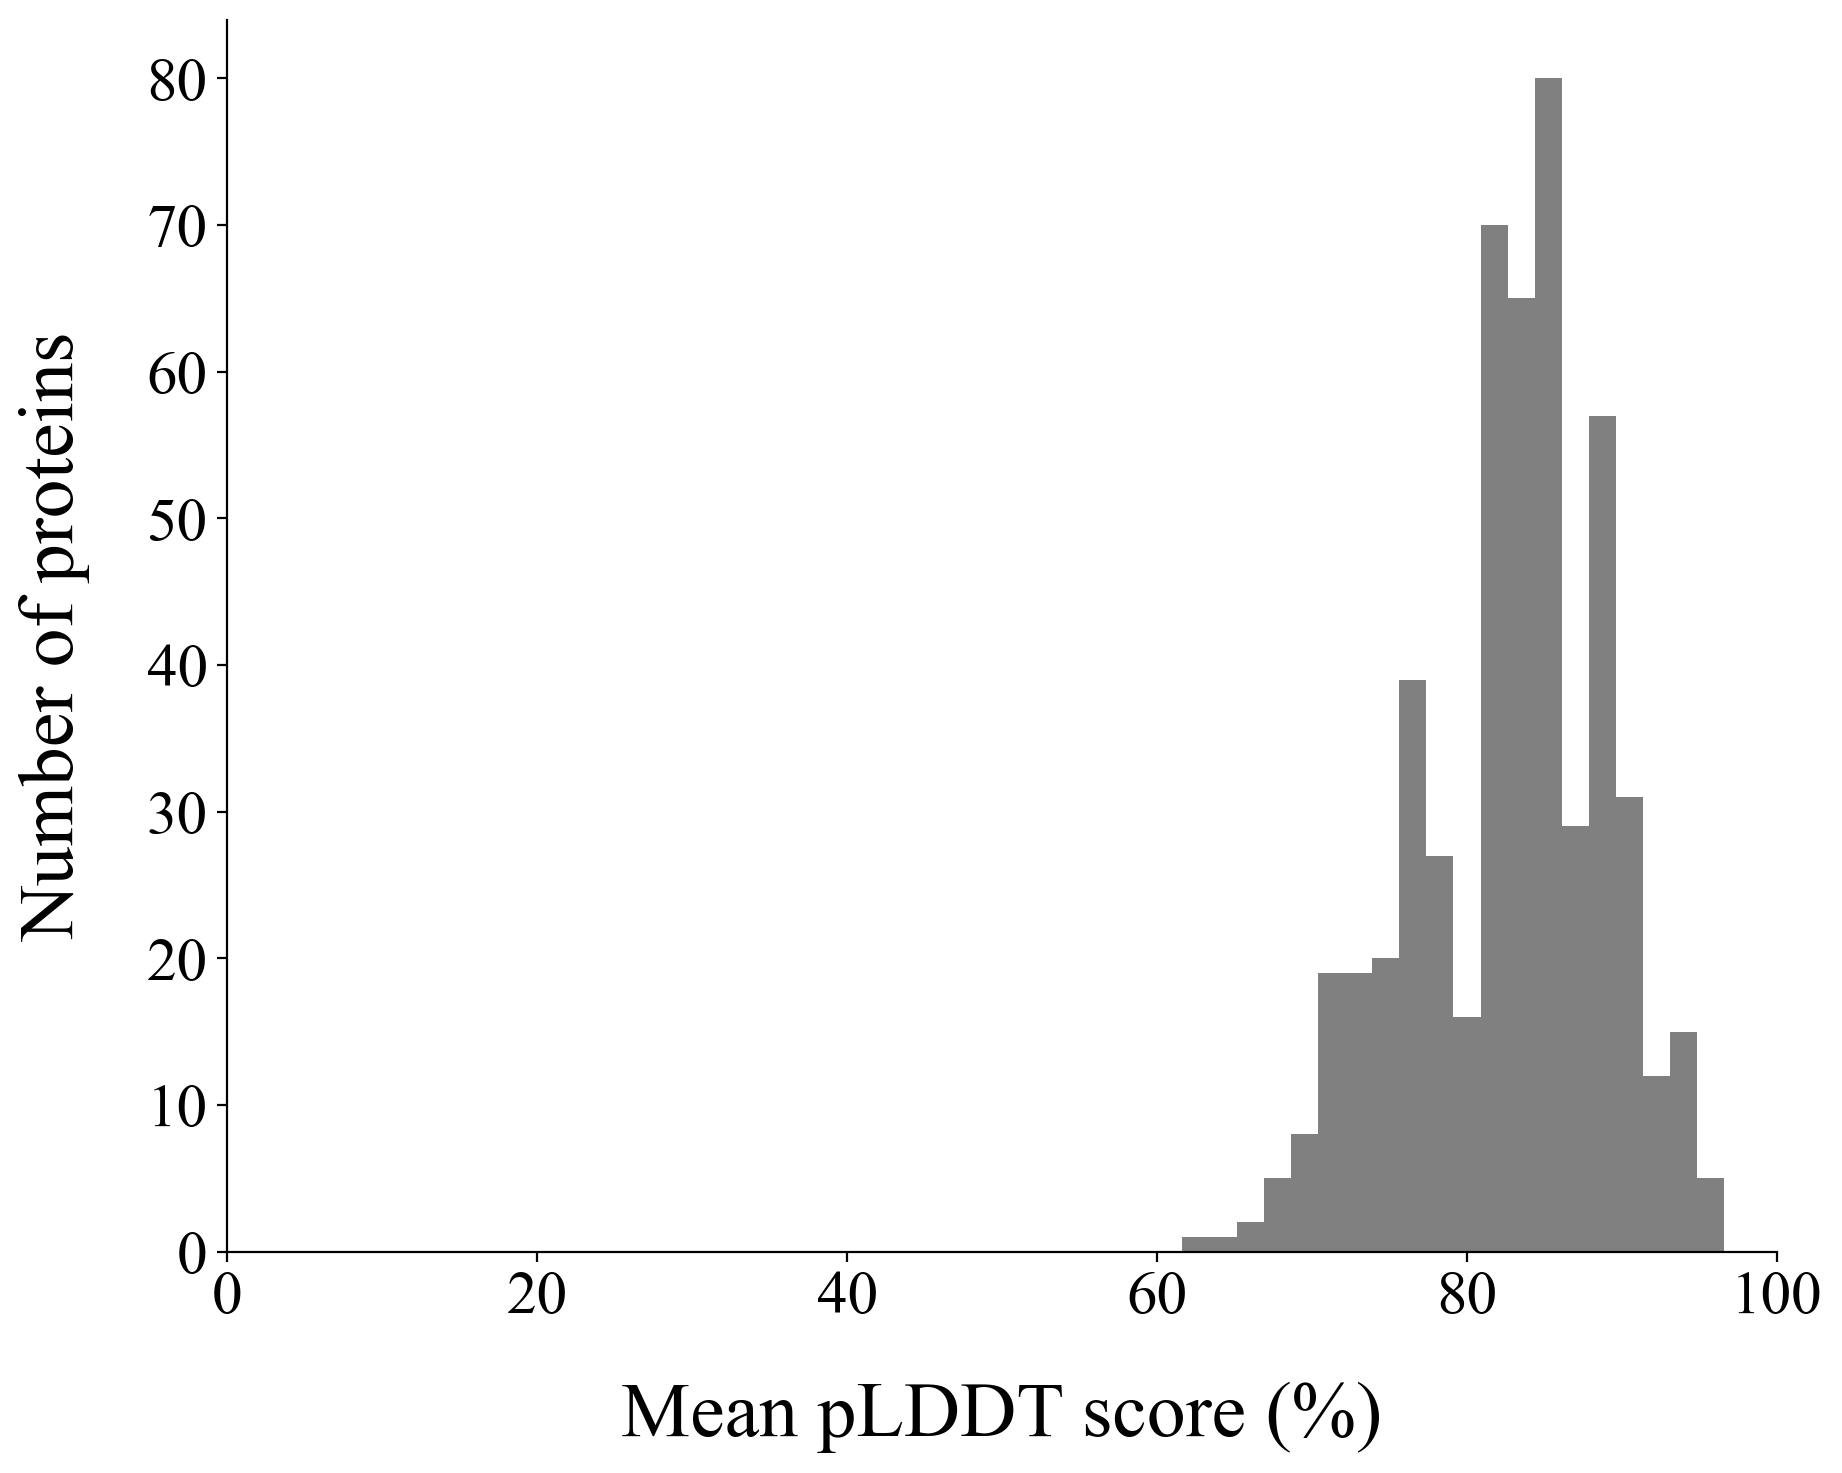

klebsiella


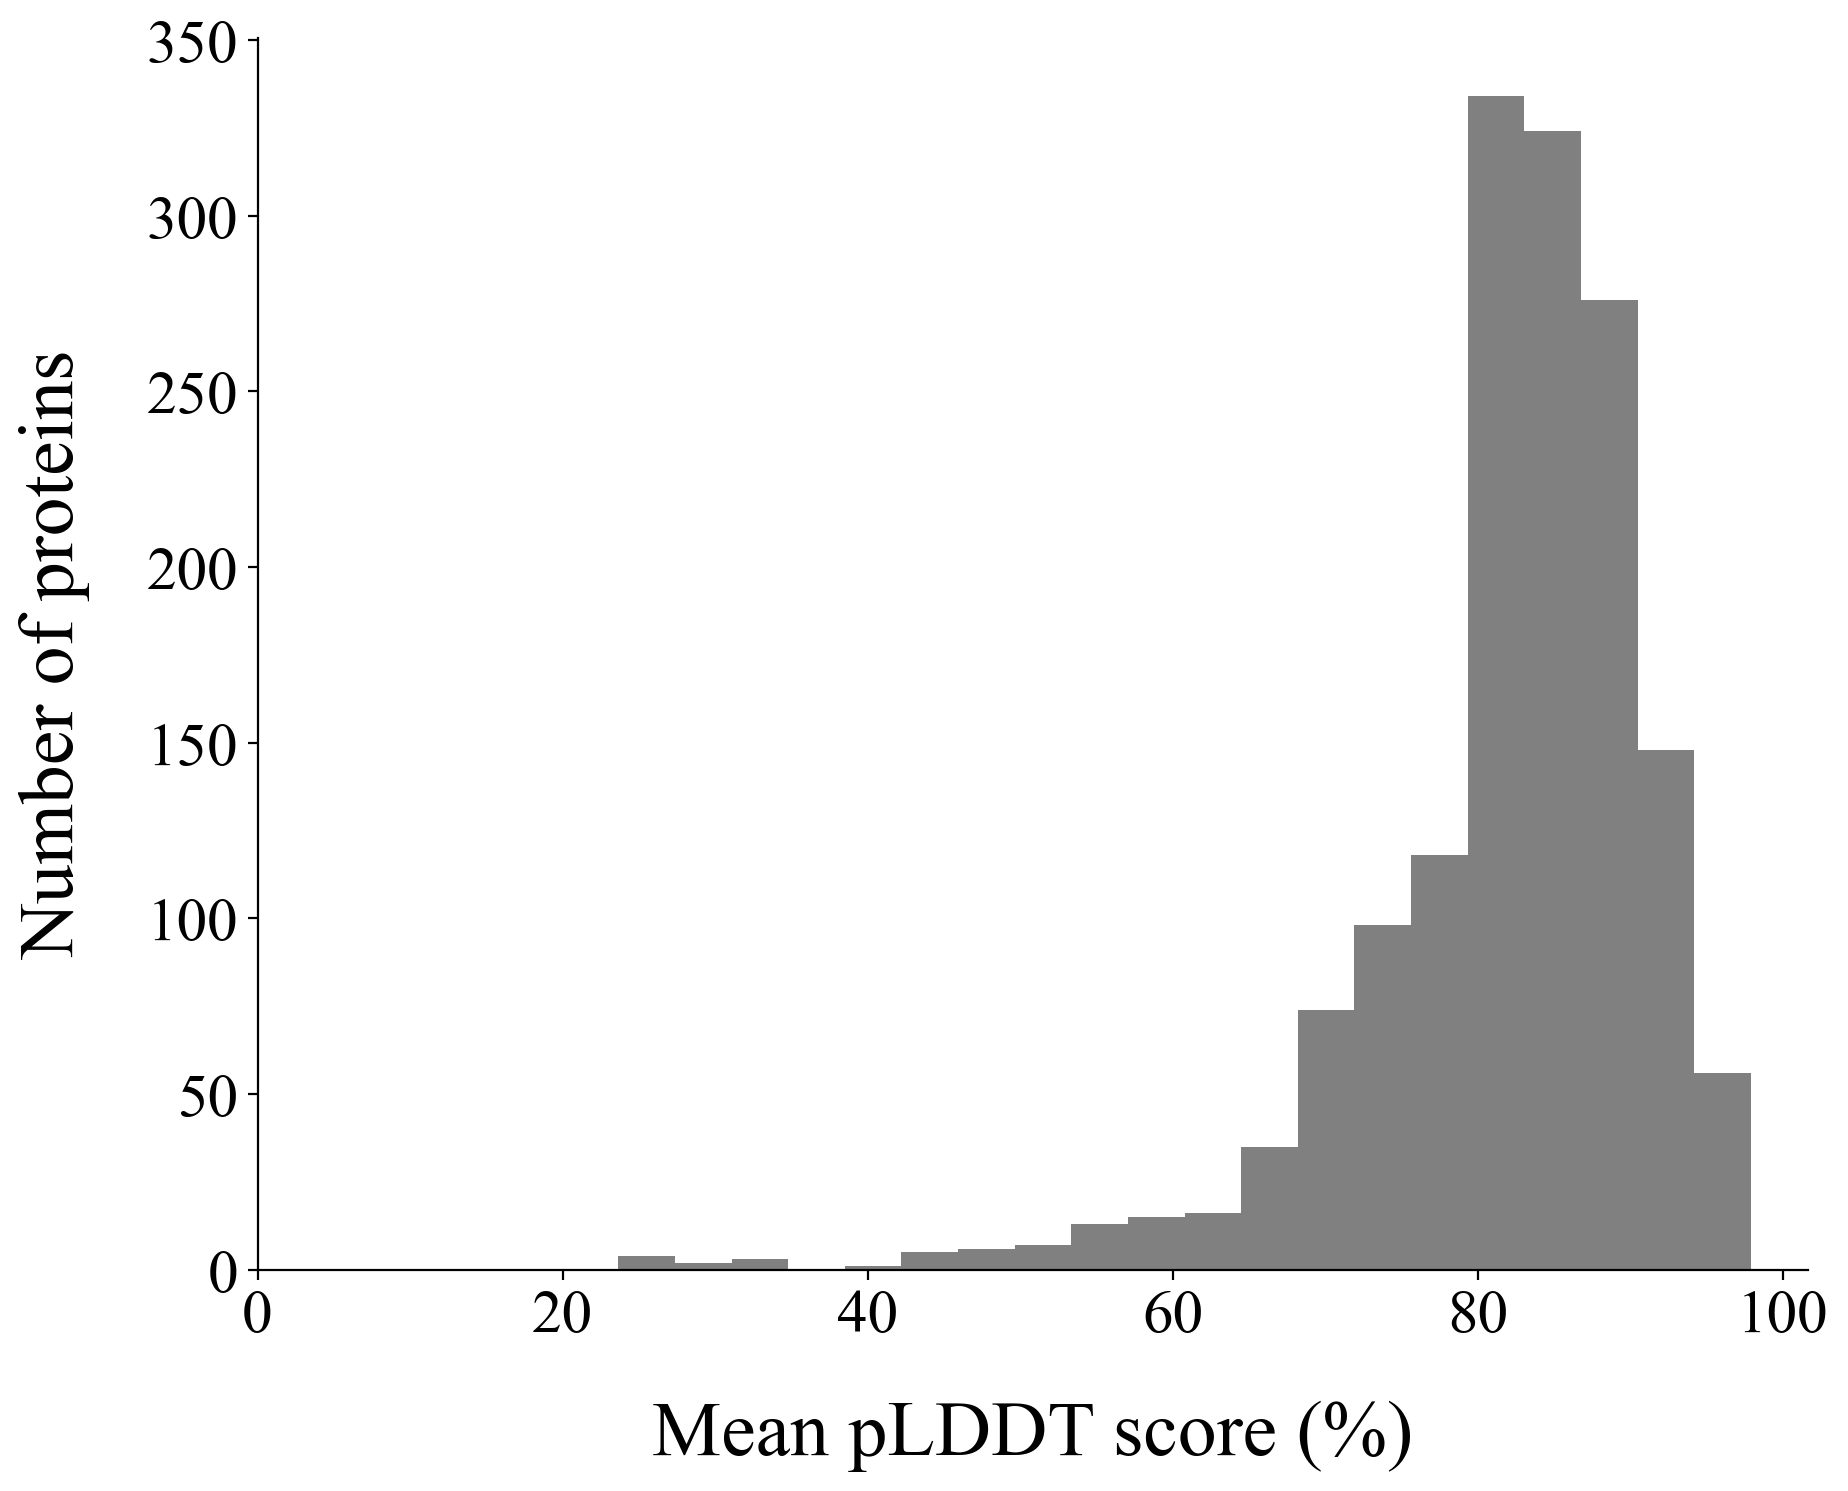

acinetobacter


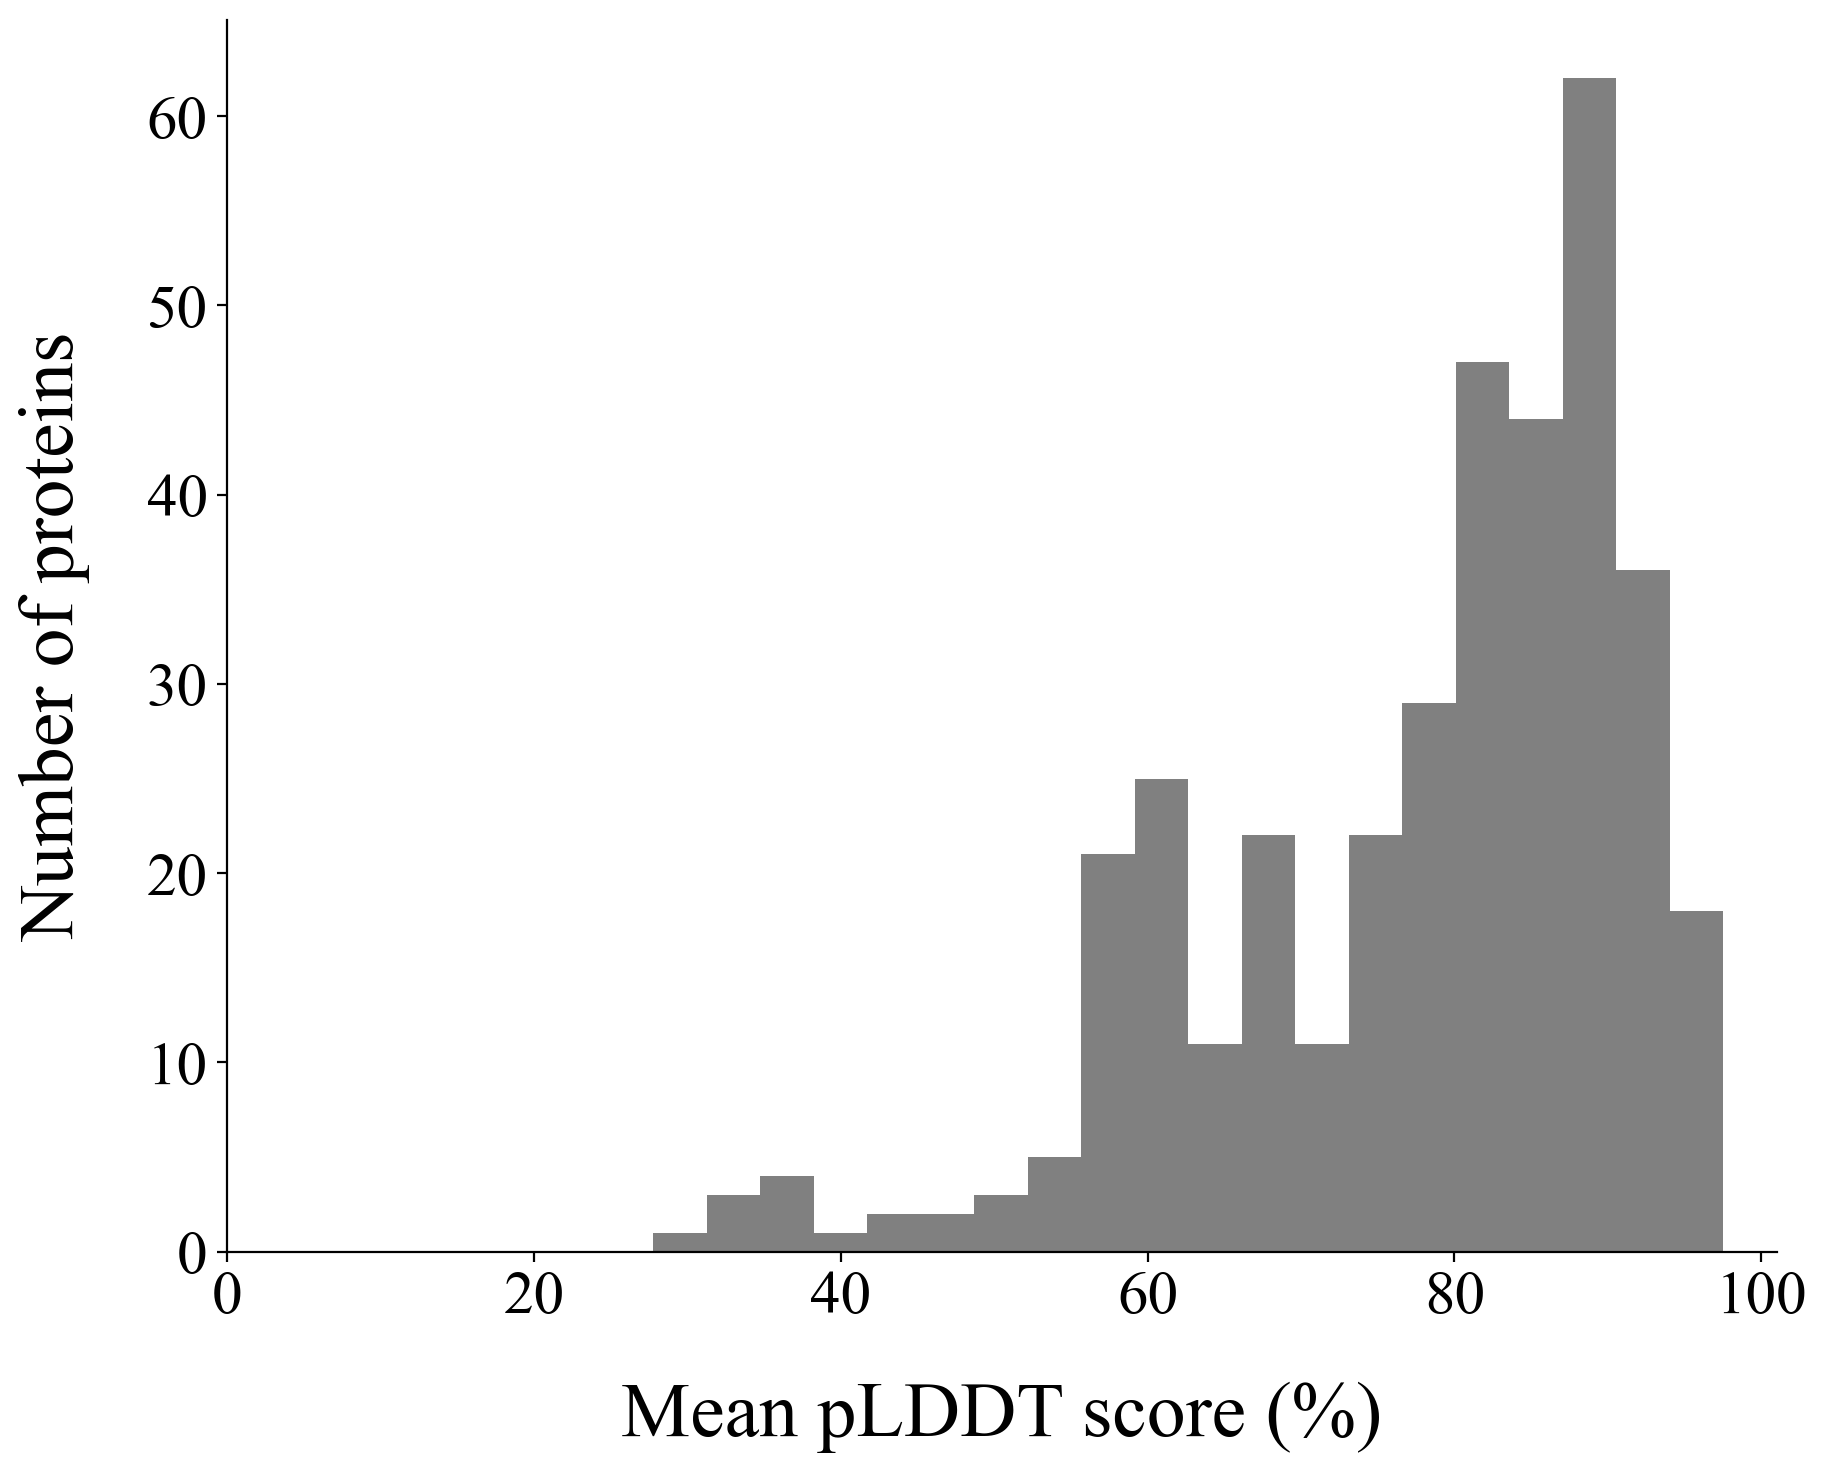

pseudomonas


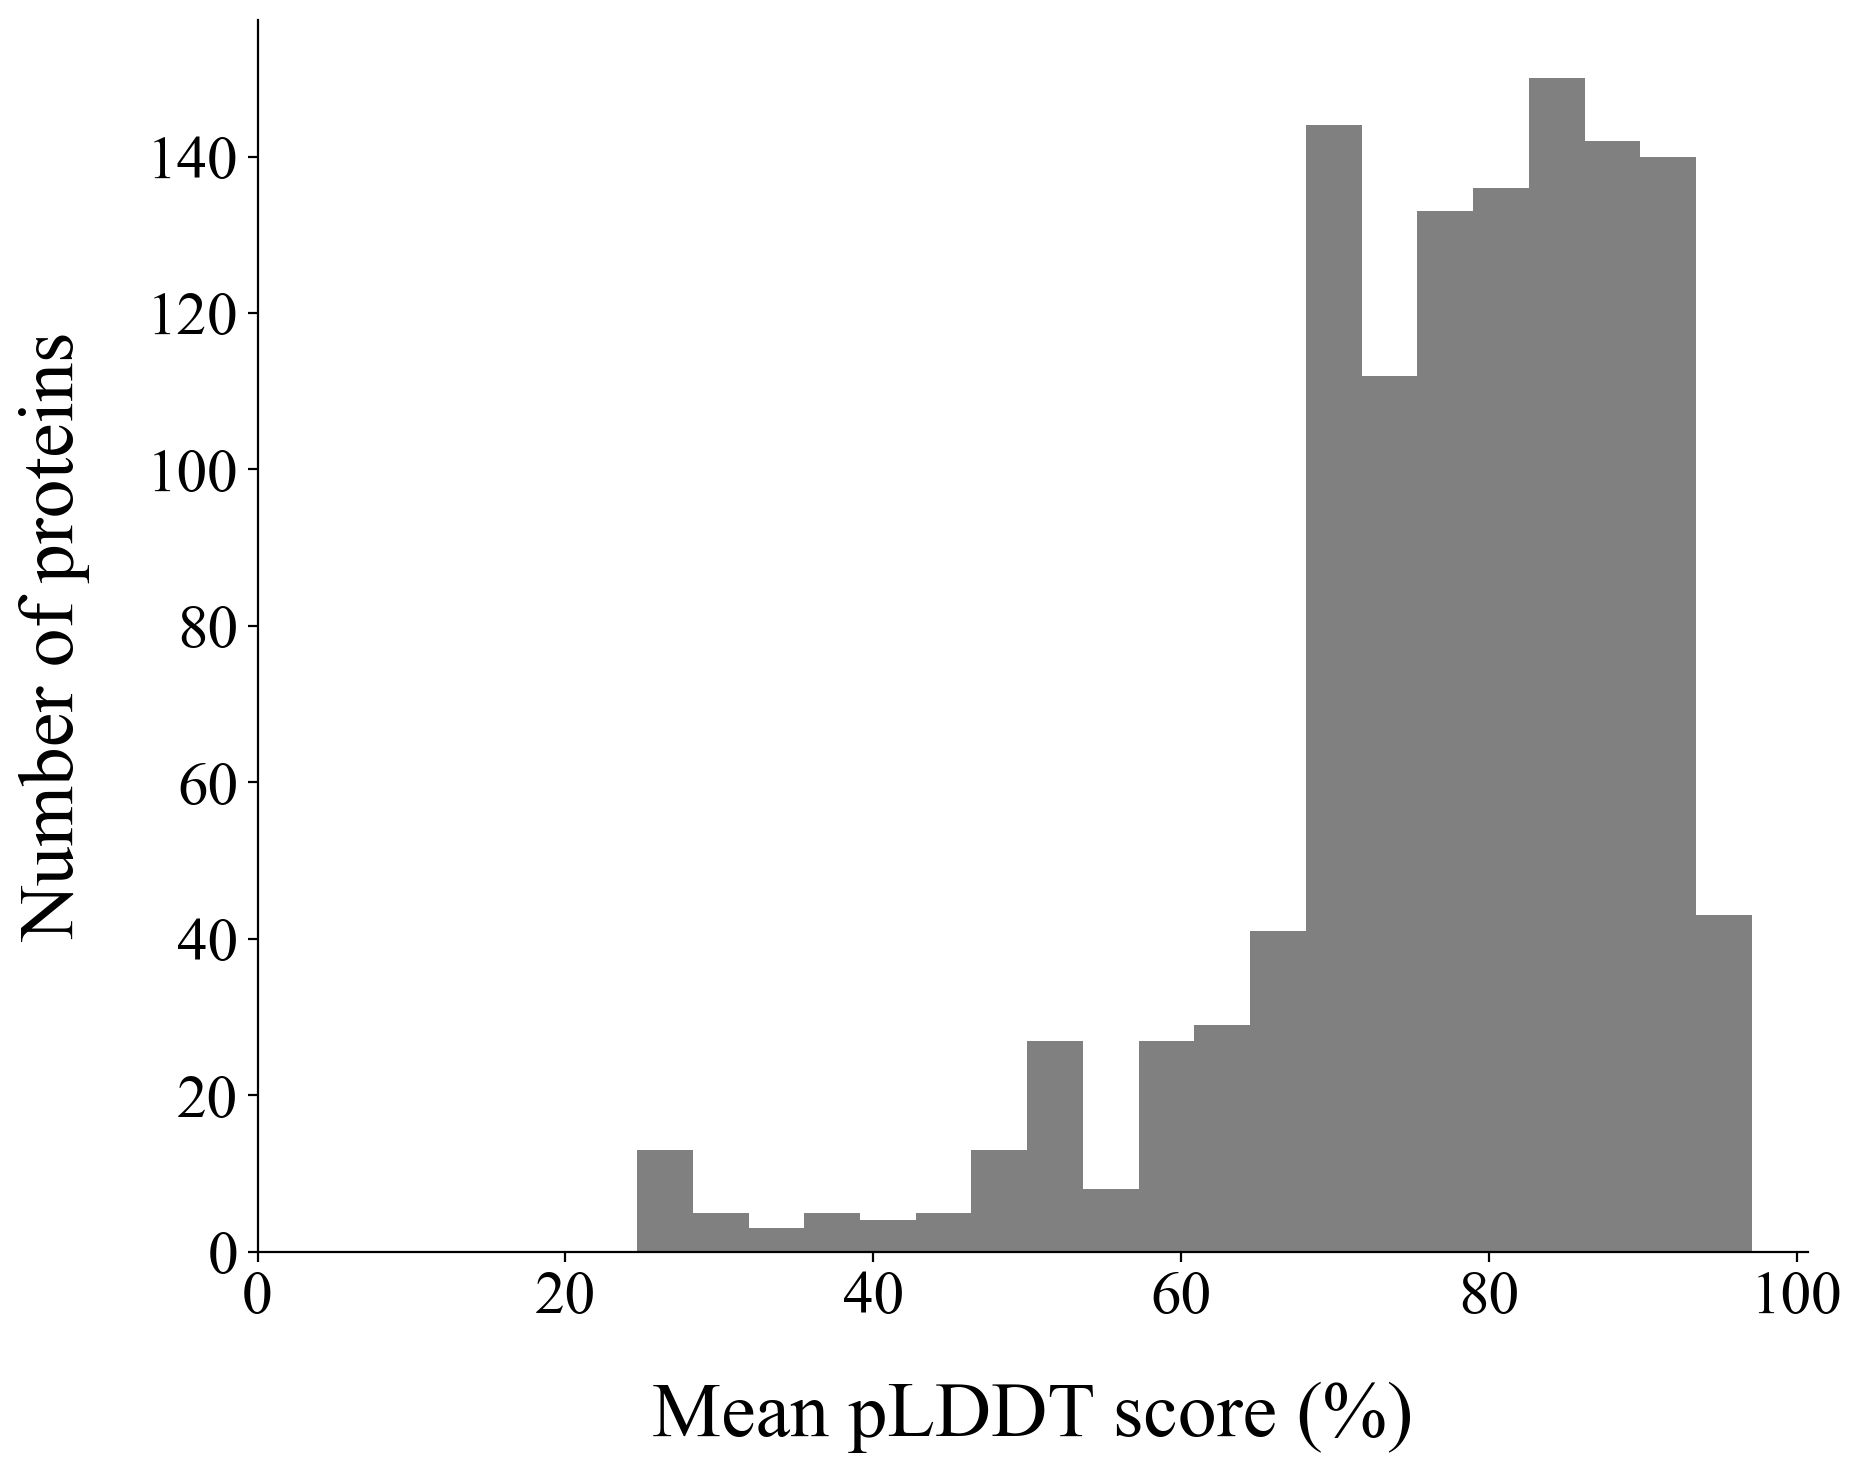

enterobacter


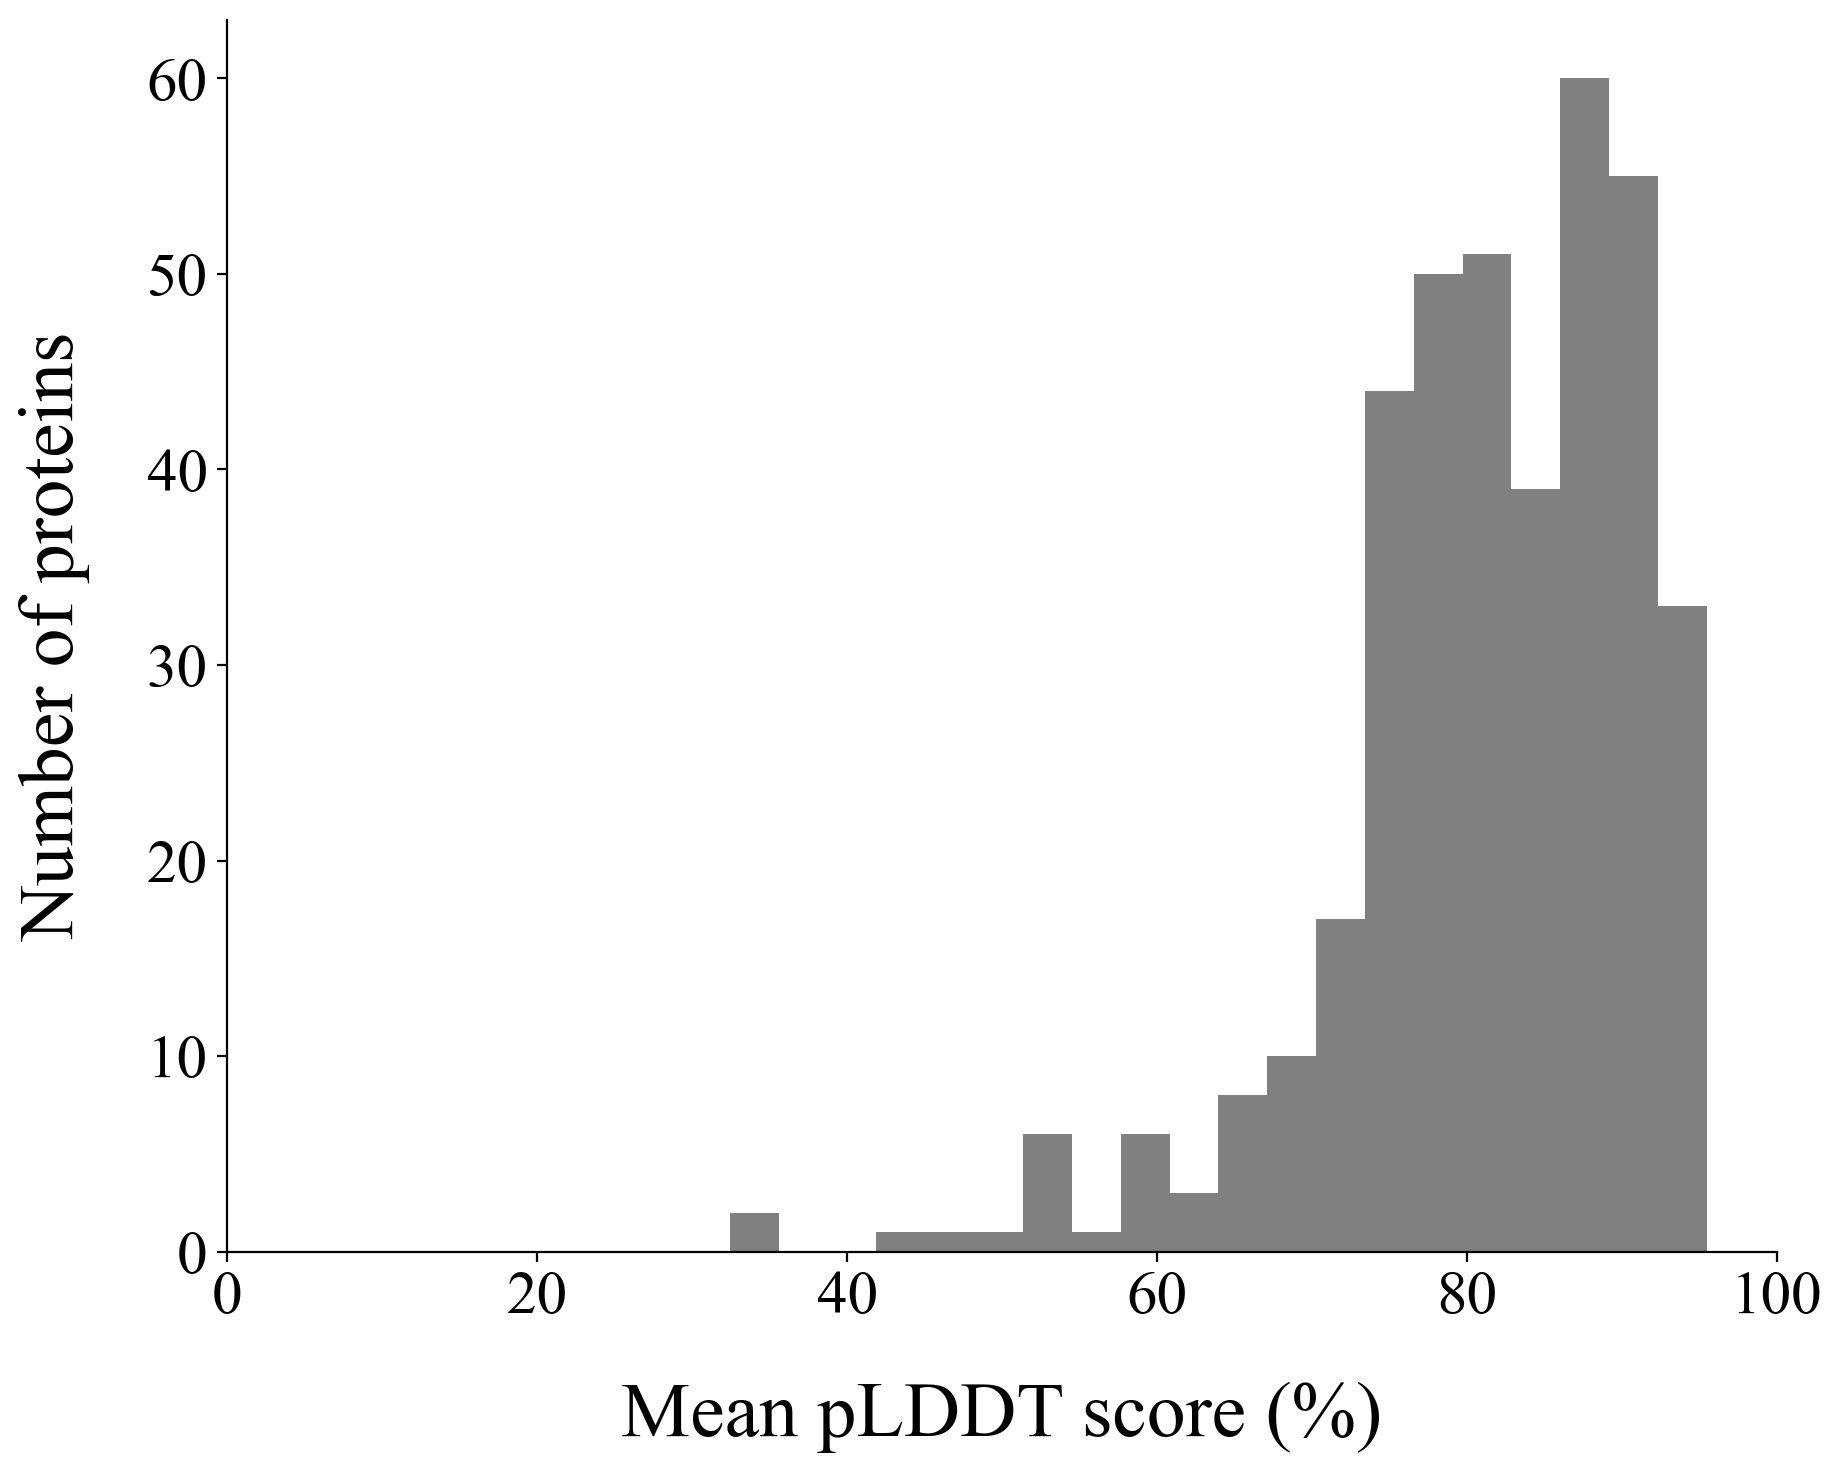

escherichia


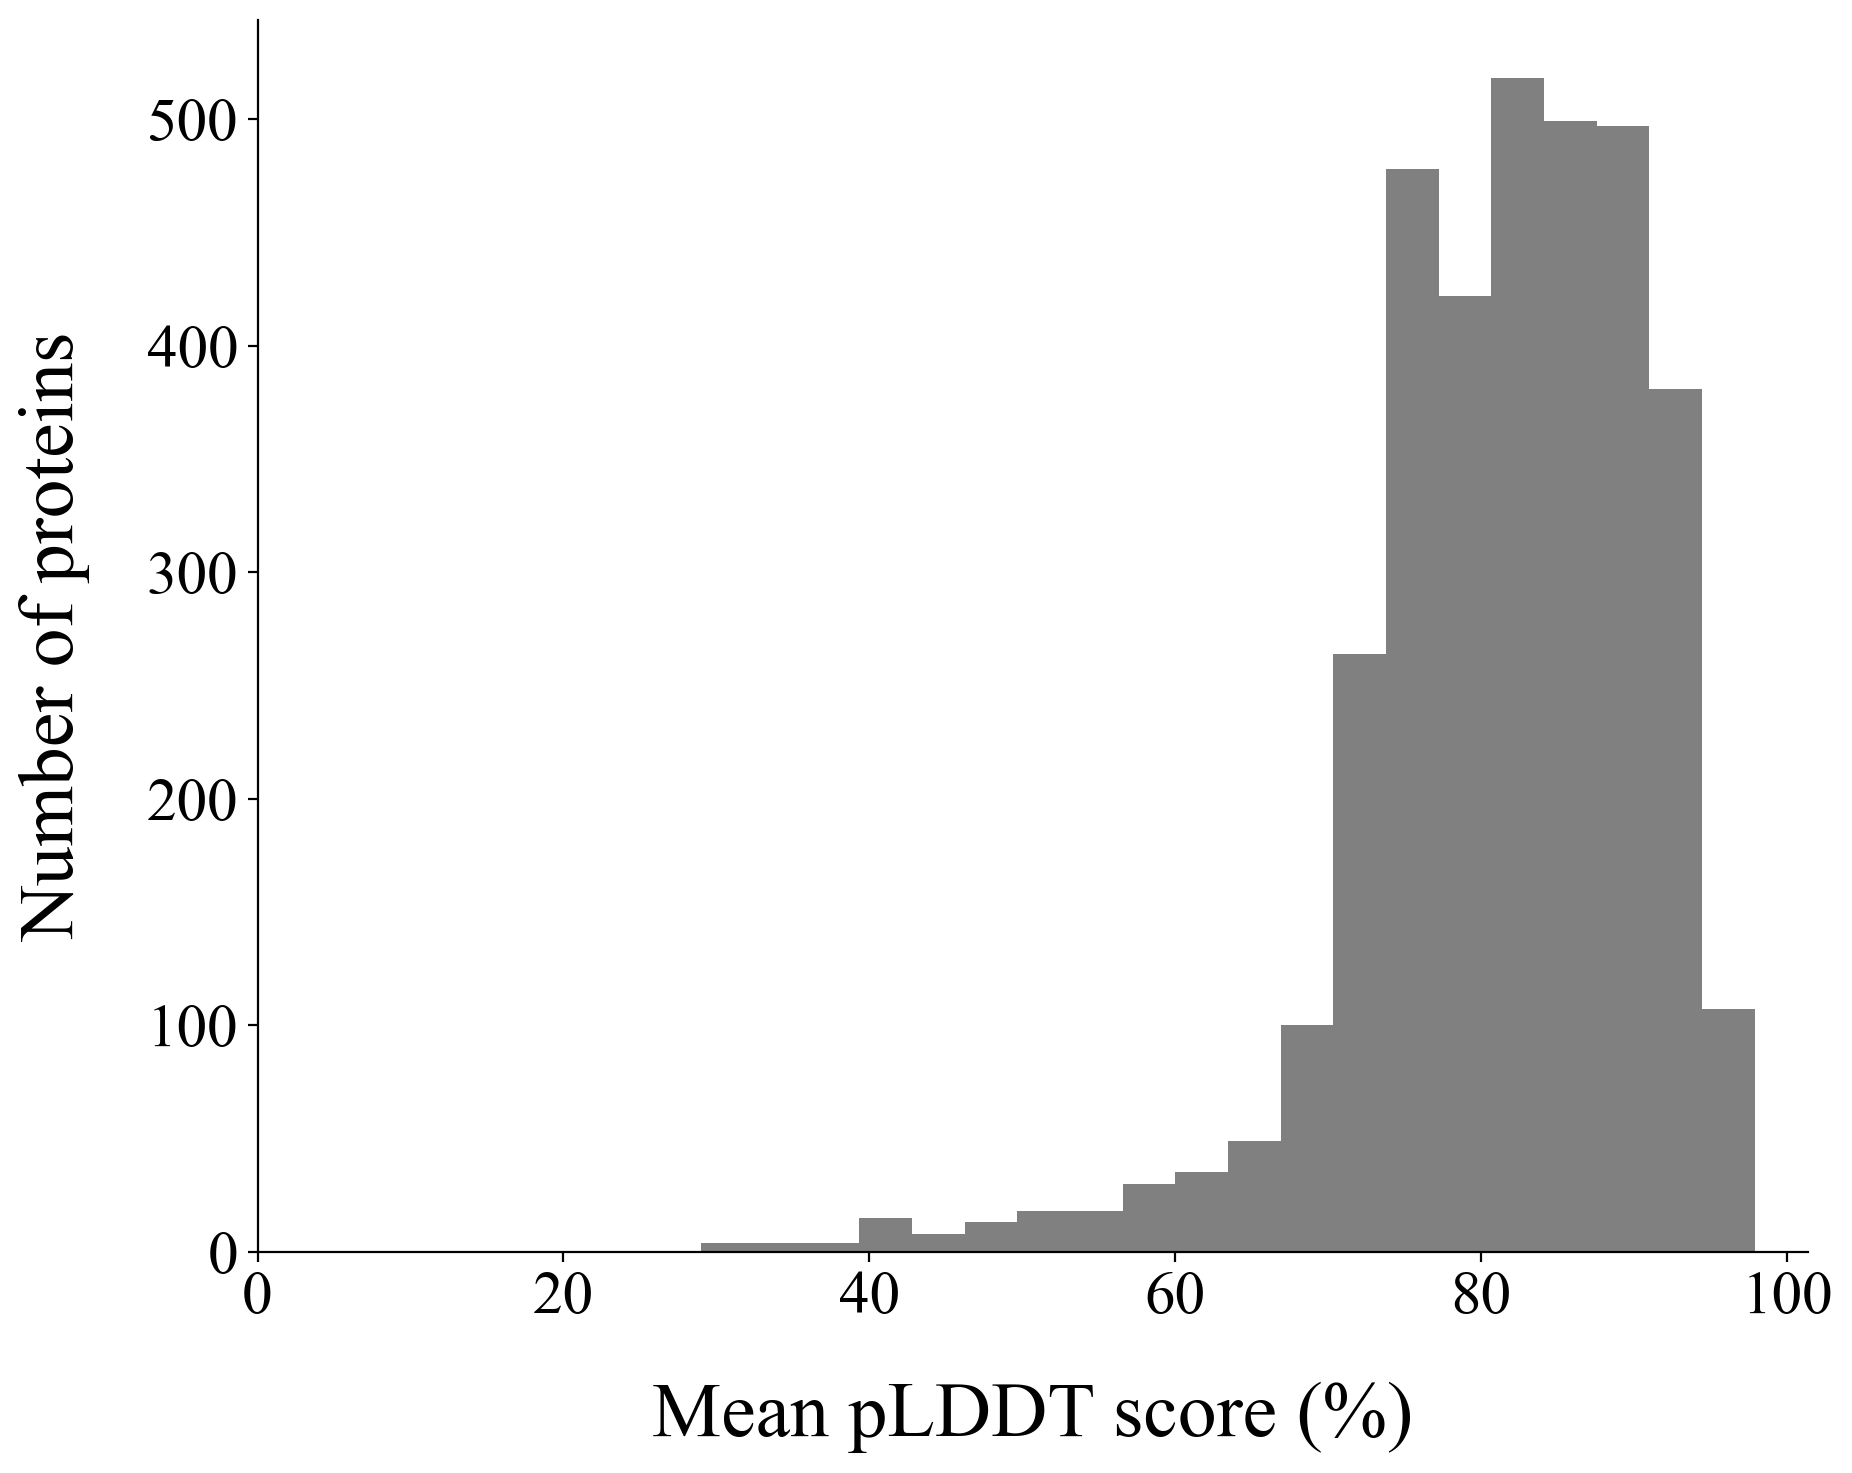

In [25]:
for label in labels:
    print(label)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 22

    fig, ax = plt.subplots(figsize=(10, 8), dpi=200)
    plt.hist(plddt_dict[label], bins=20, color="gray")
    plt.xticks(np.arange(0, 101, 20))
    plt.xlabel("Mean pLDDT score (%)", labelpad=20, fontsize=28)
    plt.ylabel("Number of proteins", labelpad=20, fontsize=28)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)
    plt.show()

Compute some descriptive statistics.

In [26]:
for genus, plddt in plddt_dict.items():
    print(genus)
    print("Mean:", mean(plddt))
    print("Median:", median(plddt))
    print("=========")

enterococcus
Mean: 77.5736356725559
Median: 80.86506648037923
staphylococcus
Mean: 82.73676486464237
Median: 83.24442490228923
klebsiella
Mean: 81.99854941403734
Median: 83.484691128312
acinetobacter
Mean: 77.79799705708614
Median: 81.53251651361366
pseudomonas
Mean: 77.48196295863879
Median: 79.50043754817031
enterobacter
Mean: 81.26131174624444
Median: 82.23686589318345
escherichia
Mean: 81.38795934061467
Median: 82.42406885398341
